#### Challenge 1   
  
- Open up a new IPython notebook
- Download a few MTA turnstile data files
- Open up a file, use csv reader to read it, make a python dict where
  there is a key for each (C/A, UNIT, SCP, STATION). These are the
  first four columns. The value for this key should be a list of
  lists. Each list in the list is the rest of the columns in a
  row. For example, one key-value pair should look like


{    ('A002','R051','02-00-00','LEXINGTON AVE'):
[
['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],
['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],
['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
...
]
}

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import numpy as np
%matplotlib inline

In [28]:
df = pd.read_csv('turnstile_180922.txt')
df.rename(index=str, columns={df.columns[-1]: "EXITS"}, inplace=True)
print(df.columns)

dt = df.DATE + ' '+ df.TIME

df['DATETIME'] = pd.to_datetime(dt, infer_datetime_format=True)
df=df.sort_values(by='DATETIME')
mydict = collections.defaultdict(list)

for row in df.itertuples():
    key = (row[1], row[2], row[3], row[4])
    value = [row[5], row[6], row[9], row[12], row[10], row[11]]
    mydict[key].append(value)

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')


In [29]:
mydict = collections.defaultdict(list)

#(Index='0', _1='A002', UNIT='R051', SCP='02-00-00', STATION='59 ST', LINENAME='NQR456W', DIVISION='BMT', DATE='09/15/2018', TIME='00:00:00', DESC='REGULAR', ENTRIES=6759219, EXITS=2291425, DATETIME=Timestamp('2018-09-15 00:00:00'), KEY='59 ST A002 R051 02-00-00')

for row in df.itertuples():
    timecheck = str(row[12].time())
    timecheck = timecheck.split(':')
    if timecheck[1]==timecheck[2]=='00' and int(timecheck[0])%4==0:
        key = (row[1], row[2], row[3], row[4])
        value = [row[5], row[6], row[9], row[12], row[10], row[11]]
        mydict[key].append(value)
    
mydict[('A002', 'R051', '02-00-00', '59 ST')][0]

['NQR456W',
 'BMT',
 'REGULAR',
 Timestamp('2018-09-15 00:00:00'),
 6759219,
 2291425]

#### Challenge 2

- Let's turn this into a time series.

 For each key (basically the control area, unit, device address and
 station of a specific turnstile), have a list again, but let the list
 be comprised of just the point in time and the count of entries.

This basically means keeping only the date, time, and entries fields
in each list. You can convert the date and time into datetime objects
-- That is a python class that represents a point in time. You can
combine the date and time fields into a string and use the
[dateutil](https://labix.org/python-dateutil) module to convert it
into a datetime object. For an example check
[this StackOverflow question](http://stackoverflow.com/questions/23385003/attributeerror-when-using-import-dateutil-and-dateutil-parser-parse-but-no).

Your new dict should look something like

{    ('A002','R051','02-00-00','LEXINGTON AVE'):
[
[datetime.datetime(2013, 3, 2, 3, 0), 3788],
[datetime.datetime(2013, 3, 2, 7, 0), 2585],
[datetime.datetime(2013, 3, 2, 12, 0), 10653],
[datetime.datetime(2013, 3, 2, 17, 0), 11016],
[datetime.datetime(2013, 3, 2, 23, 0), 10666],
[datetime.datetime(2013, 3, 3, 3, 0), 10814],
[datetime.datetime(2013, 3, 3, 7, 0), 10229],
...
],
....
}

-15832600
32225788
37857.564000000246


0.011503234357381655

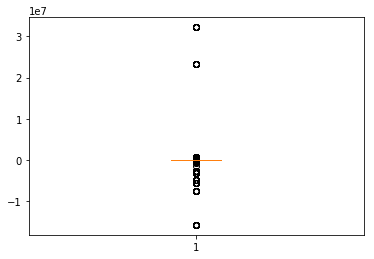

In [30]:
points = []
errors = []

for key in mydict:
    entries = mydict[key]
    lastentry = entries[0][4]
    lastexit = entries[0][5]
    for entry in entries:
        check_entry = entry[4]-lastentry
        check_exit = entry[5]-lastexit
        points.append(check_entry)
        points.append(check_exit)
        if check_entry < 0 or check_entry > 75000:
            errors.append([key,entry, 'entry',check_entry])
        if check_exit < 0 or check_exit > 75000:
            errors.append([key,entry, 'exit',check_exit])
            

plt.boxplot(points)
print(min(points))
print(max(points))
print(np.percentile(points, 99.9))
a = len(points)
b =((np.array(points)<0) | (np.array(points)>40000)).sum()

b/a

In [31]:
station_errors =[]
time_errors = []

for error in errors:
    station = error[0][3]
    station_errors.append(station)
    time = error[1][3].time()
    time_errors.append(time)
    
time_errors = pd.Series(time_errors)
time_errors.value_counts()
    
station_errors=pd.Series(station_errors)
station_errors.value_counts()

59 ST              164
42 ST-PORT AUTH    164
104 ST             151
34 ST-HERALD SQ    123
3 AV-149 ST        123
57 ST-7 AV         123
149/GRAND CONC     100
6 AV                82
COURT SQ            82
190 ST              82
METROPOLITAN AV     82
FRANKLIN AV         82
14 ST               82
LEXINGTON AV/63     82
GRAND-NEWTOWN       82
CORTELYOU RD        80
168 ST              52
50 ST               42
JAMAICA CENTER      41
86 ST               41
DEKALB AV           41
CHAMBERS ST         41
LEXINGTON AV/53     41
PROSPECT PARK       41
TIMES SQ-42 ST      41
HIGH ST             41
JAMAICA 179 ST      40
75 AV               40
82 ST-JACKSON H     40
GRAND ST            28
NASSAU AV            6
75 ST-ELDERTS        4
dtype: int64

In [32]:
#note, this adds entry and exit data together, and removes errors of negative numbers 
#and numbers larger than 75000
#should we change the upper clip? If this is a single gate, 10000 is an absurd number

challenge2 = collections.defaultdict(list)

for key in mydict:
    entries = mydict[key]
    lastentry = entries[0][4]
    lastexit = entries[0][5]
    for entry in entries:
        check_entry = entry[4]-lastentry
        if check_entry < 0:
            check_entry = 0
        if check_entry > 75000 :
            check_entry = 0
        check_exit = entry[5]-lastexit
        if check_exit < 0:
            check_exit = 0
        if check_exit > 75000 :
            check_exit = 0
        value = [entry[3], check_entry+check_exit]
        lastentry = entry[4]
        lastexit = entry[5]
        challenge2[key].append(value)
print(challenge2[('A002', 'R051', '02-00-00', '59 ST')][0:5])

[[Timestamp('2018-09-15 00:00:00'), 0], [Timestamp('2018-09-15 04:00:00'), 19], [Timestamp('2018-09-15 08:00:00'), 41], [Timestamp('2018-09-15 12:00:00'), 158], [Timestamp('2018-09-15 16:00:00'), 250]]


#### Challenge 3

- These counts are for every n hours. (What is n?) We want total daily
  entries.

Now make it that we again have the same keys, but now we have a single
value for a single day, which is the total number of passengers that
entered through this turnstile on this day.


In [55]:
challenge2[('A002', 'R051', '02-00-00', '59 ST')][0][0].date()

datetime.date(2018, 9, 15)

In [56]:
challenge3= collections.defaultdict(list)

dates = collections.defaultdict(int)

for key in challenge2:
    entries = challenge2[key]
    for entry in entries:
        date = entry[0].date()
        dates[date] += entry[1]
    for date in dates:
        challenge3[key].append([date, dates[date]])

        
print(challenge3[('A002', 'R051', '02-00-00', '59 ST')])   

[[datetime.date(2018, 9, 15), 772], [datetime.date(2018, 9, 16), 568], [datetime.date(2018, 9, 17), 1758], [datetime.date(2018, 9, 18), 1871], [datetime.date(2018, 9, 19), 1804], [datetime.date(2018, 9, 20), 2001], [datetime.date(2018, 9, 21), 2083]]


#### Challenge 4

We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:

    %matplotlib inline

This will make your matplotlib graphs integrate nicely with the
notebook. To plot the time series, import matplotlib with

    import matplotlib.pyplot as plt

Take the list of [(date1, count1), (date2, count2), ...], for the
turnstile and turn it into two lists:
dates and counts. This should plot it:

    plt.figure(figsize=(10,3))
    plt.plot(dates,counts)


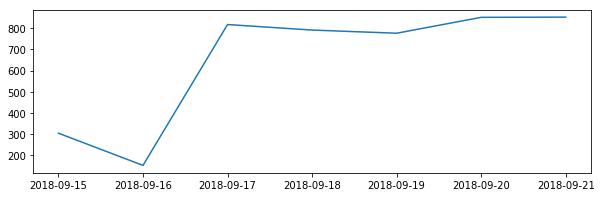

In [35]:
dates = []
counts = []

for entry in challenge3[('A002', 'R051', '02-00-00', '59 ST')]:
    dates.append(entry[0])
    counts.append(entry[1])

plt.figure(figsize=(10,3))
plt.plot(dates,counts)

#### Challenge 5

- So far we've been operating on a single turnstile level, let's
  combine turnstiles in the same ControlArea/Unit/Station combo. There
  are some ControlArea/Unit/Station groups that have a single
  turnstile, but most have multiple turnstilea-- same value for the
  C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each
ControlArea/UNIT/STATION combo, for each day, add the counts from each
turnstile belonging to that combo.

In [36]:
challenge5 = collections.defaultdict(list)

dates = collections.defaultdict(int)

for key in challenge3:
    newkey = (key[0], key[1], key[3])
    dates = collections.defaultdict(int)
    for entry in challenge3[key]:
        dates[entry[0]] += entry[1]
    for date in dates:
        challenge5[newkey].append([date, dates[date]])

for key in challenge5:
    week = collections.defaultdict(int)
    for item in challenge5[key] :
        date=item[0]
        increase = item[1]
        week[date] += increase
    challenge5[key] = []
    for day in week:
        challenge5[key].append([day, week[day]])
        
print(challenge5[('A002', 'R051', '59 ST')])

[[datetime.date(2018, 9, 15), 3310], [datetime.date(2018, 9, 16), 2421], [datetime.date(2018, 9, 17), 7489], [datetime.date(2018, 9, 18), 7090], [datetime.date(2018, 9, 19), 6844], [datetime.date(2018, 9, 20), 7744], [datetime.date(2018, 9, 21), 7697]]


#### Challenge 6

Similarly, combine everything in each station, and come up with a time
series of `[(date1, count1),(date2,count2),...]` type of time series
for each STATION, by adding up all the turnstiles in a station.

In [37]:
challenge6 = collections.defaultdict(list)
dates = collections.defaultdict(int)

for key in challenge3:
    newkey = (key[3])
    dates = collections.defaultdict(int)
    for entry in challenge3[key]:
        dates[entry[0]] += entry[1]
    for date in dates:
        challenge6[newkey].append([date, dates[date]])

for key in challenge6:
    week = collections.defaultdict(int)
    for item in challenge6[key] :
        date=item[0]
        increase = item[1]
        week[date] += increase
    challenge6[key] = []
    for day in week:
        challenge6[key].append([day, week[day]])
        
print(challenge6[('59 ST')])

[[datetime.date(2018, 9, 15), 18328], [datetime.date(2018, 9, 16), 14751], [datetime.date(2018, 9, 17), 38481], [datetime.date(2018, 9, 18), 36047], [datetime.date(2018, 9, 19), 35699], [datetime.date(2018, 9, 20), 41073], [datetime.date(2018, 9, 21), 39226]]


#### Challenge 7

Plot the time series for a station.

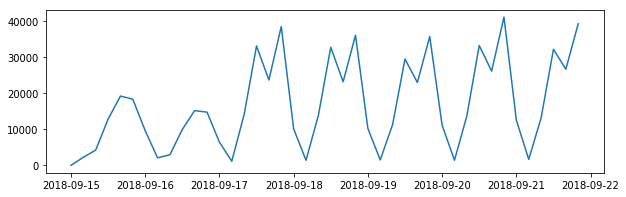

In [38]:
challenge7 = collections.defaultdict(list)
dates = collections.defaultdict(int)

for key in challenge2:
    newkey = (key[3])
    dates = collections.defaultdict(int)
    for entry in challenge2[key]:
        dates[entry[0]] += entry[1]
    for date in dates:
        challenge7[newkey].append([date, dates[date]])

for key in challenge7:
    week = collections.defaultdict(int)
    for item in challenge7[key] :
        date=item[0]
        increase = item[1]
        week[date] += increase
    challenge7[key] = []
    for day in week:
        challenge7[key].append([day, week[day]])
        
dates = []
counts = []

for entry in challenge7[('59 ST')]:
    dates.append(entry[0])
    counts.append(entry[1])

plt.figure(figsize=(10,3))
plt.plot(dates,counts)
    

#### Challenge 8

- Make one list of counts for **one** week for one station. Monday's
  count, Tuesday's count, etc. so it's a list of 7 counts.
  Make the same list for another week, and another week, and another
  week.
  `plt.plot(week_count_list)` for every `week_count_list` you created
  this way. You should get a rainbow plot of weekly commute numbers on
  top of each other.

/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


DATETIME
2018-09-15 00:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-15 04:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-15 08:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-15 12:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-15 16:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-15 20:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-16 00:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-16 04:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-16 08:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-16 12:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-16 16:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-16 20:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-17 00:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-17 04:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-17 08:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-17 12:00:00    AxesSubplot(0.125,0.125;0.775x0.755)
2018-09-17 16:00:00    AxesSubp

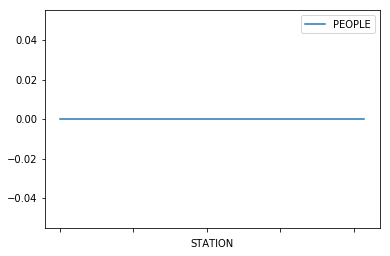

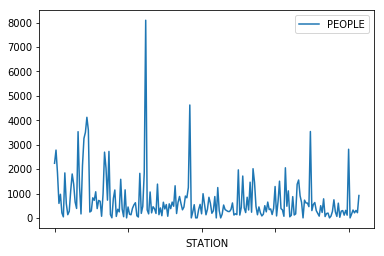

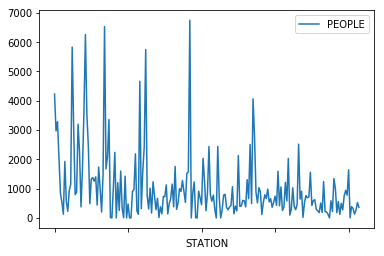

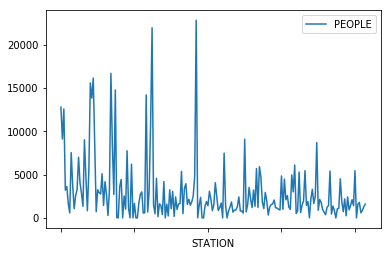

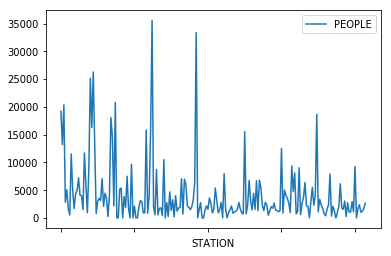

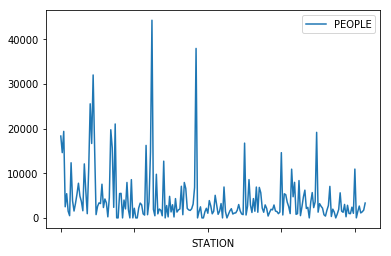

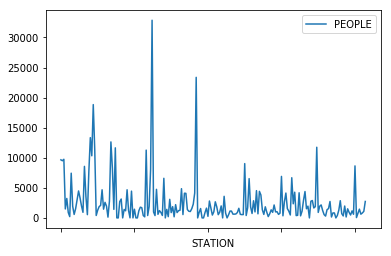

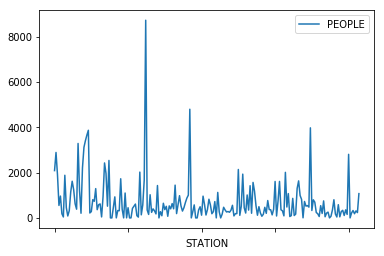

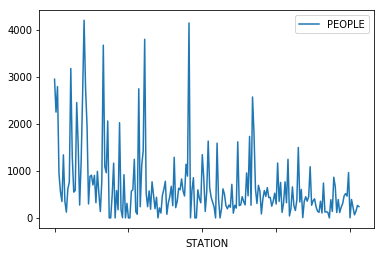

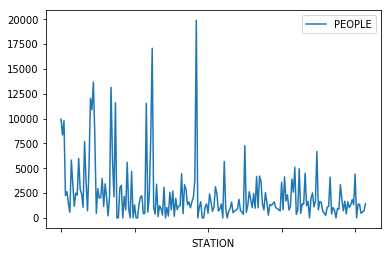

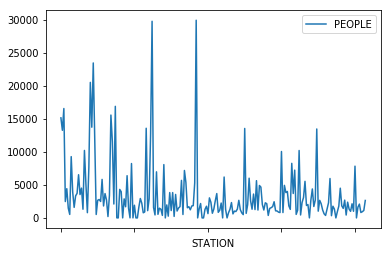

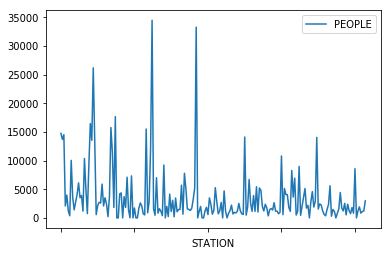

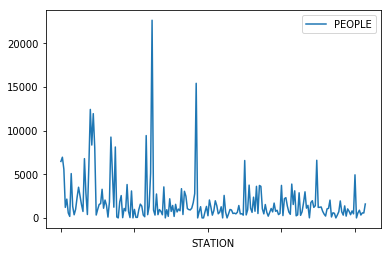

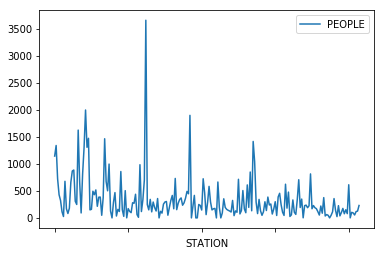

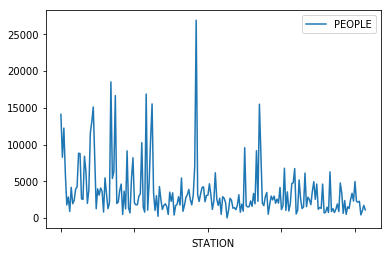

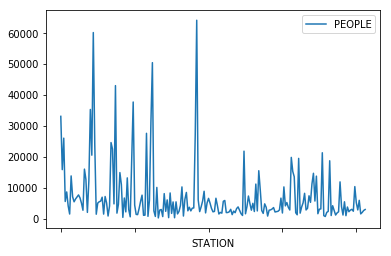

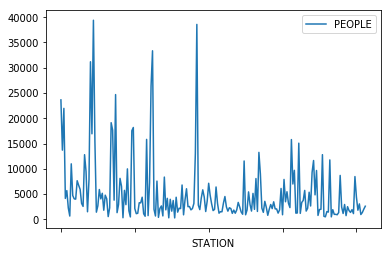

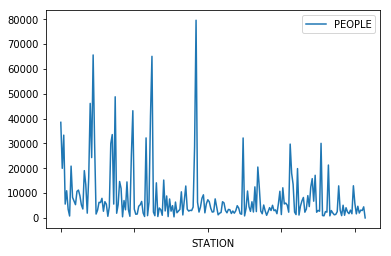

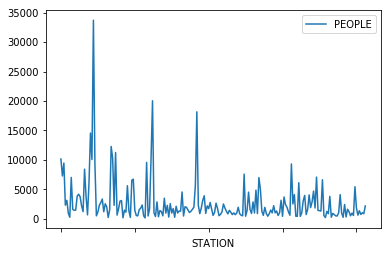

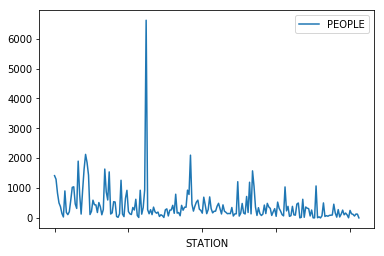

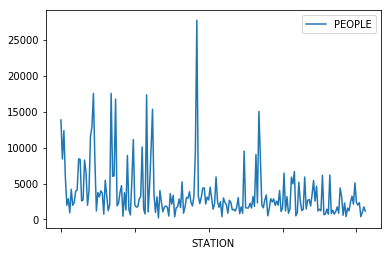

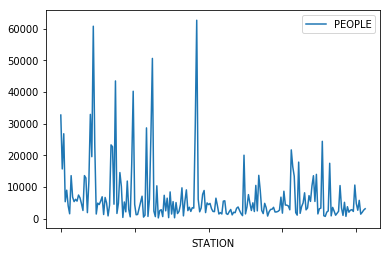

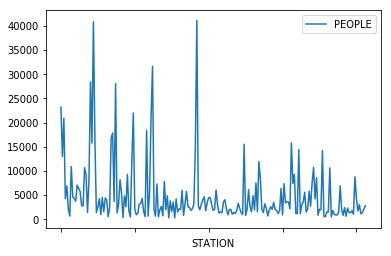

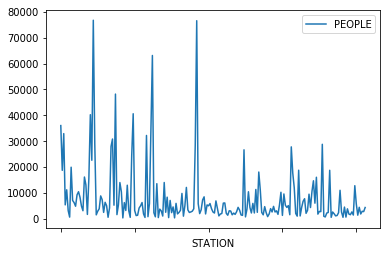

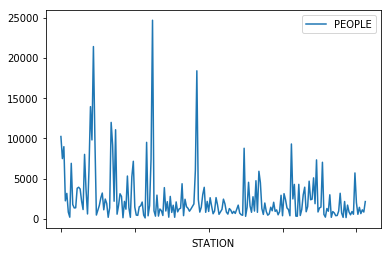

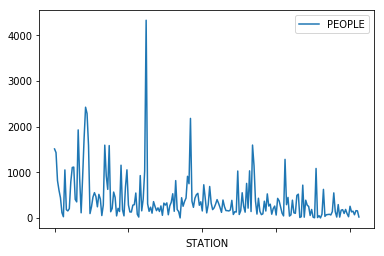

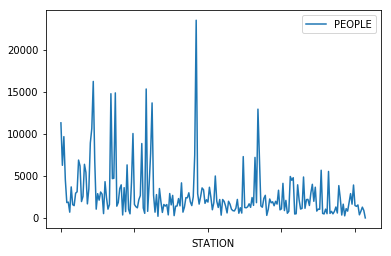

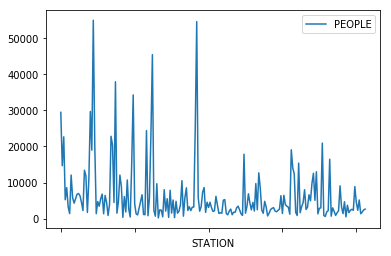

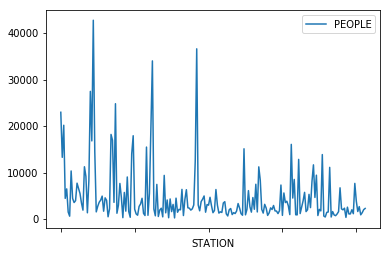

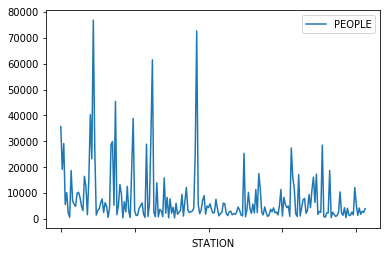

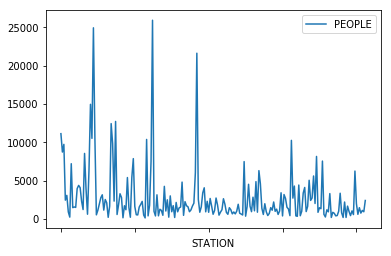

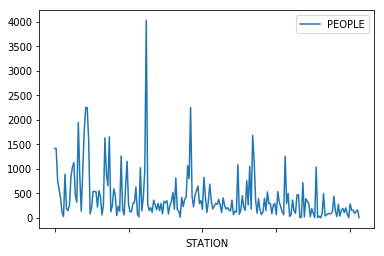

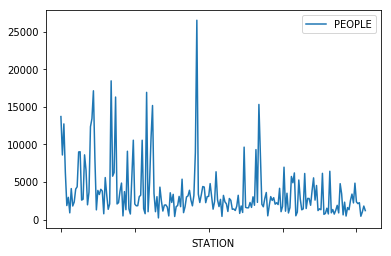

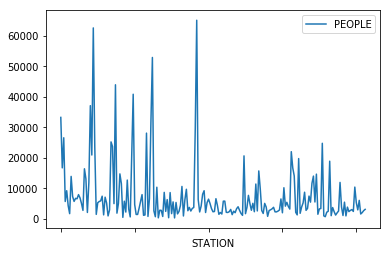

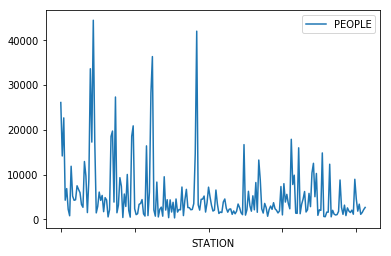

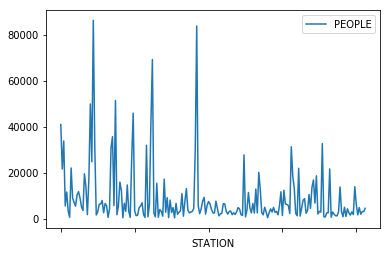

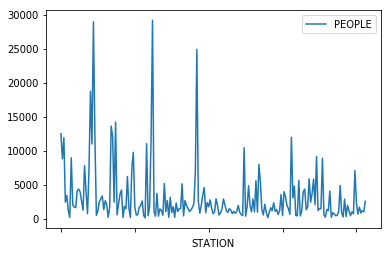

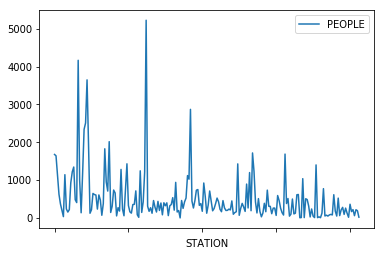

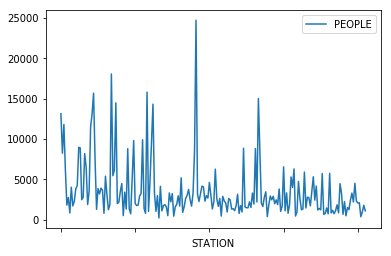

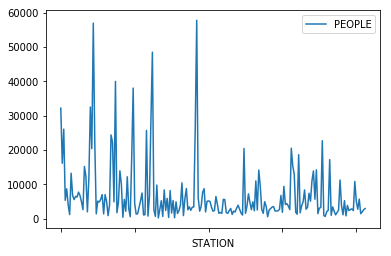

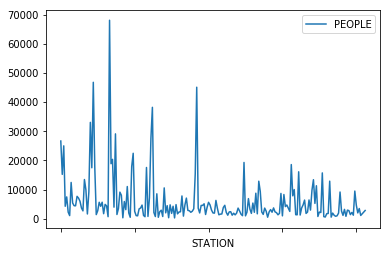

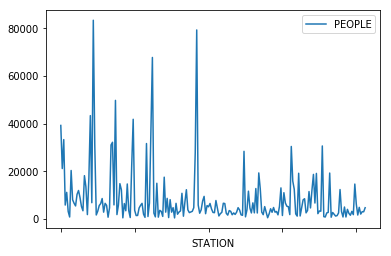

In [53]:
#the right answer is to make a TIDY dataframe

records = []

for key in challenge7:
    for item in challenge7[key]:
        record = tuple([key, item[0], item[1]])
        records.append(record)

df2 = pd.DataFrame.from_records(records, columns = ['STATION', 'DATETIME', 'PEOPLE'])
#df2.groupby('STATIONS').plot('DATETIME', 'PEOPLE')
#df2.groupby('DATETIME').plot('STATION', 'PEOPLE')

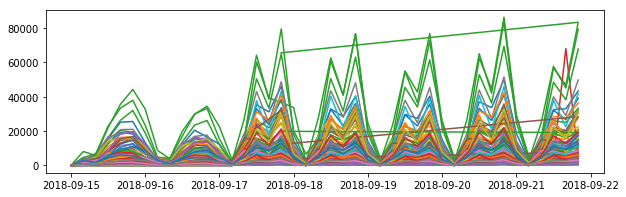

In [39]:
plt.figure(figsize=(10,3))

for key in challenge7:
    dates = []
    counts = []
    for entry in challenge7[key]:
        dates.append(entry[0])
        counts.append(entry[1])
    plt.plot(dates,counts)

/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


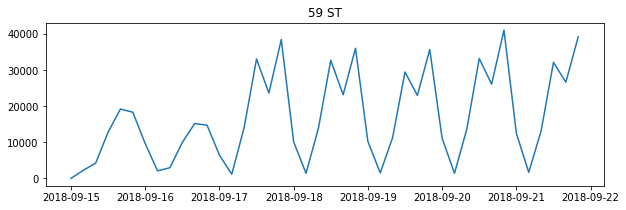

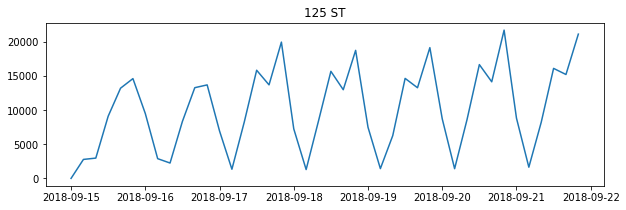

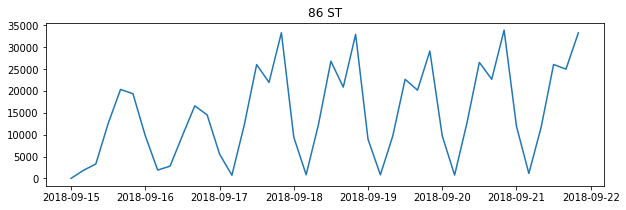

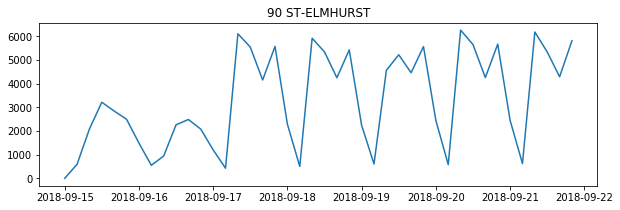

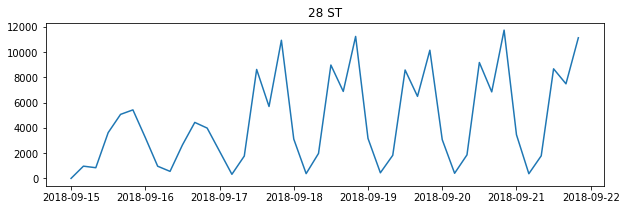

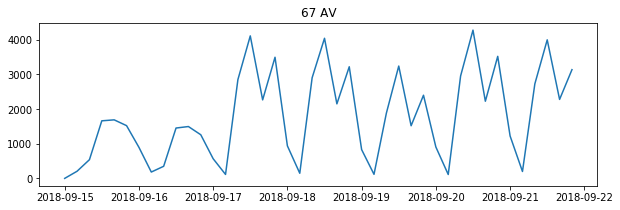

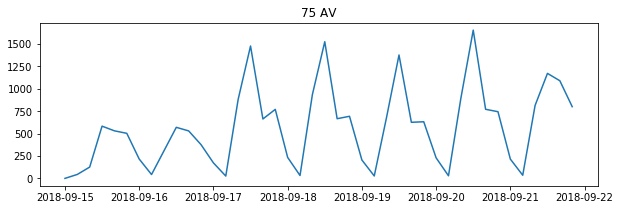

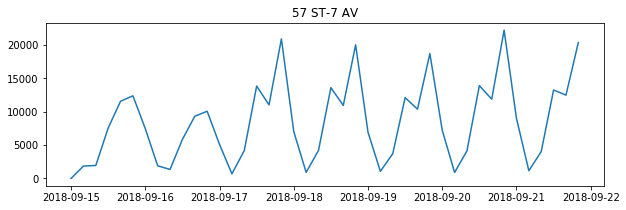

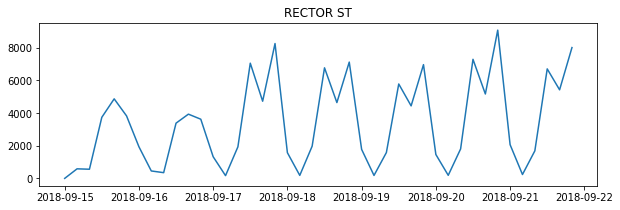

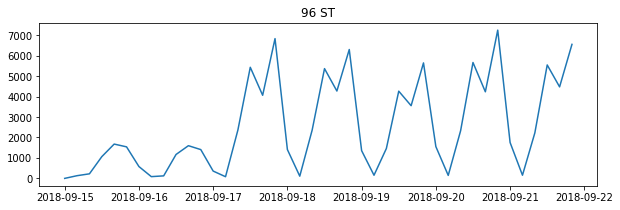

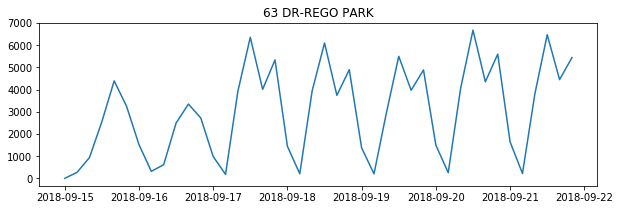

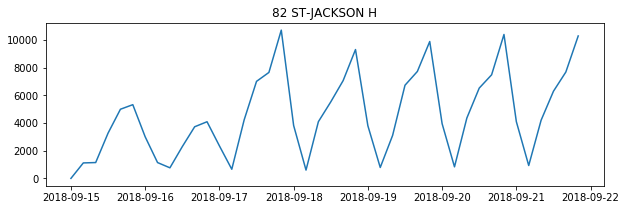

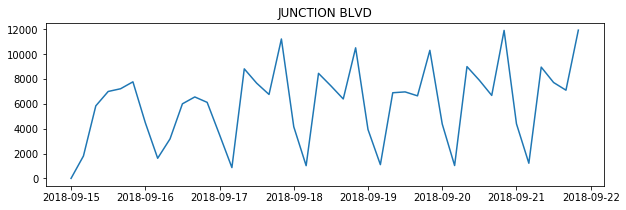

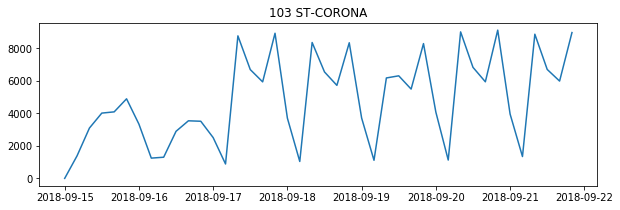

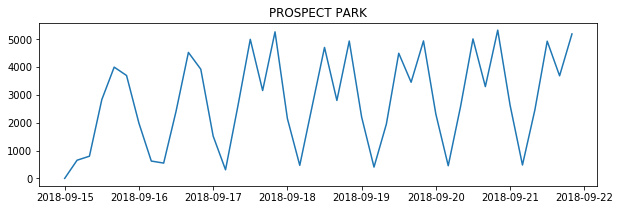

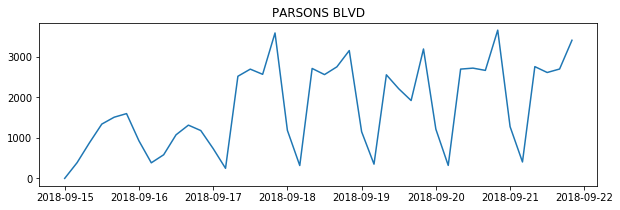

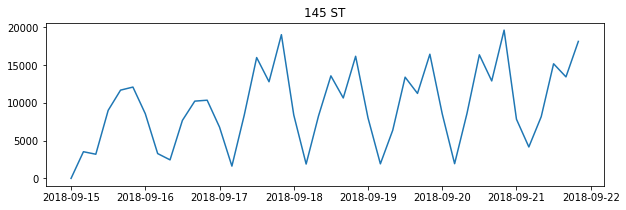

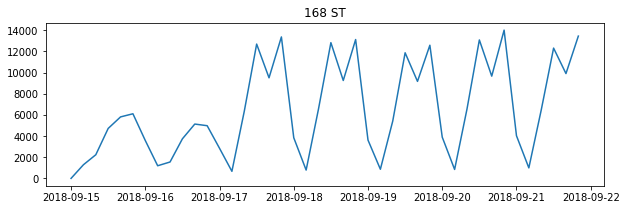

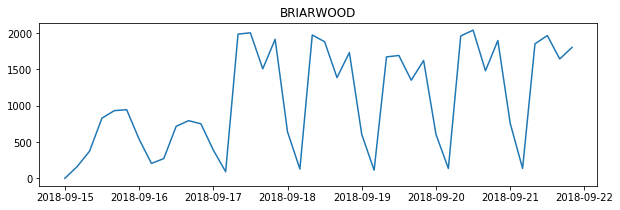

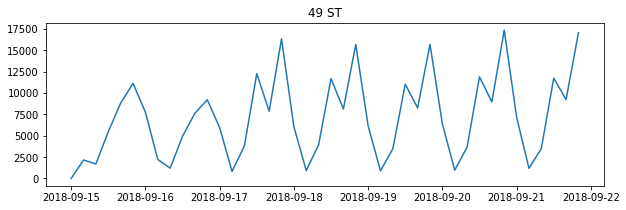

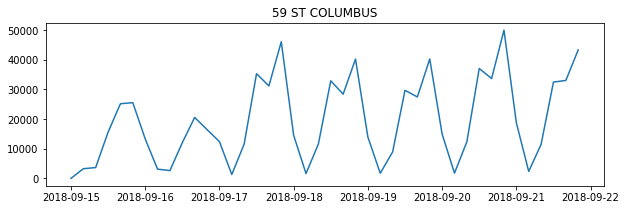

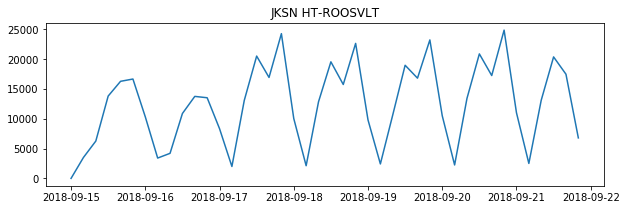

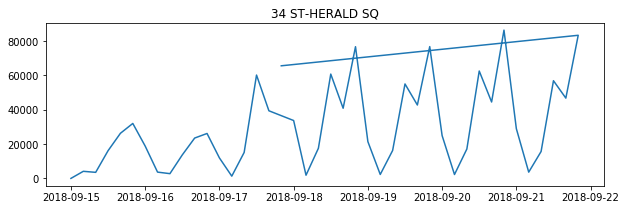

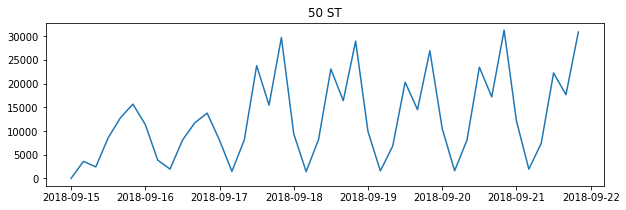

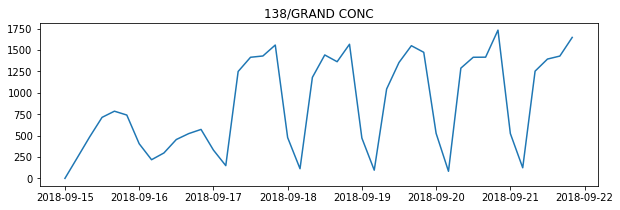

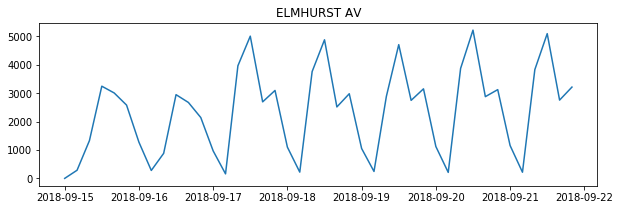

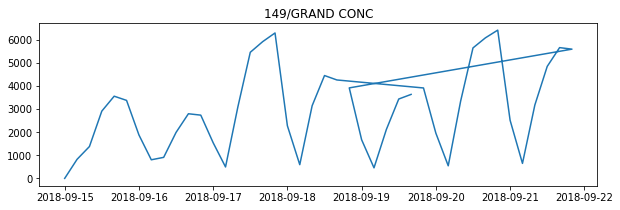

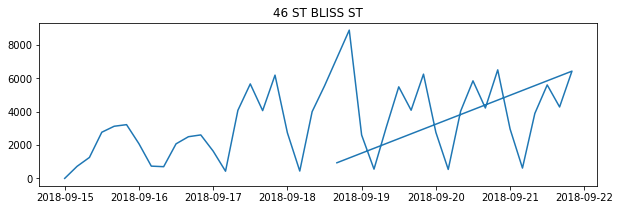

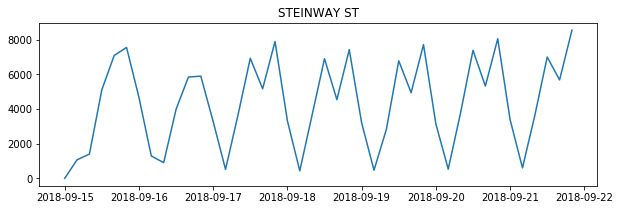

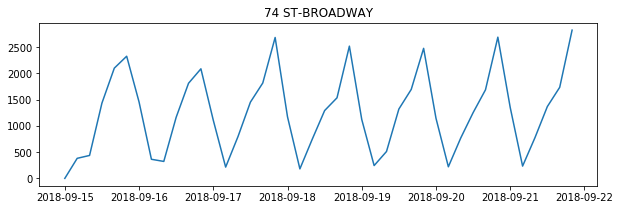

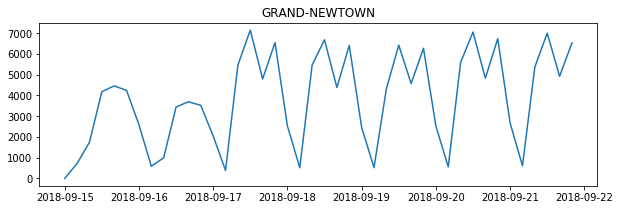

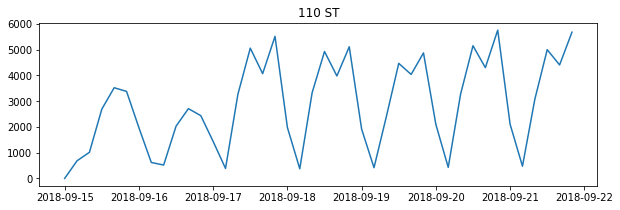

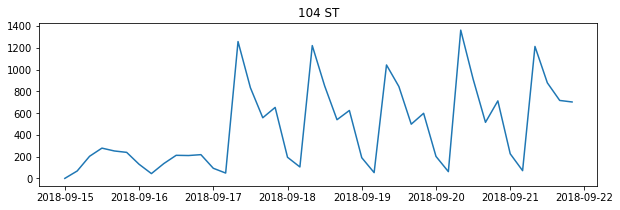

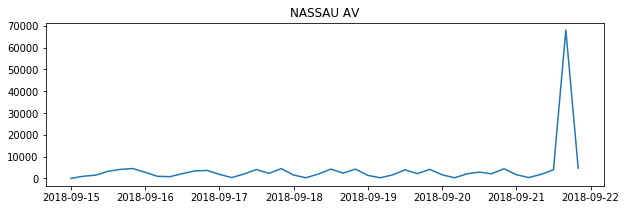

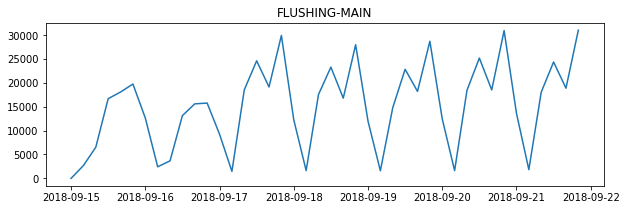

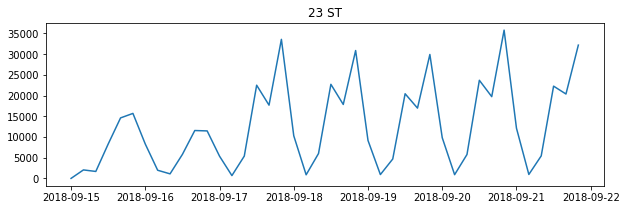

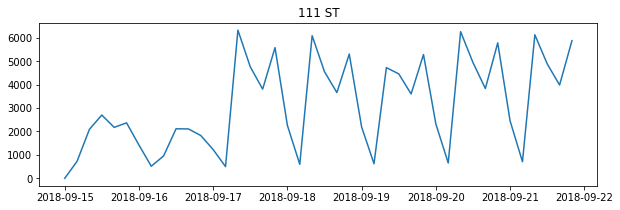

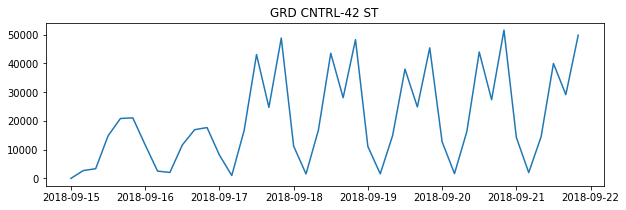

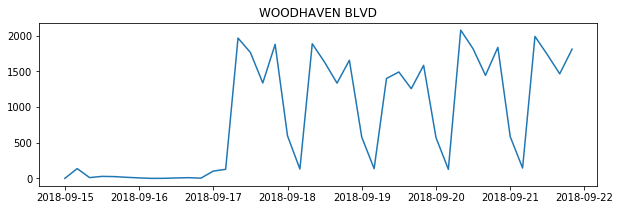

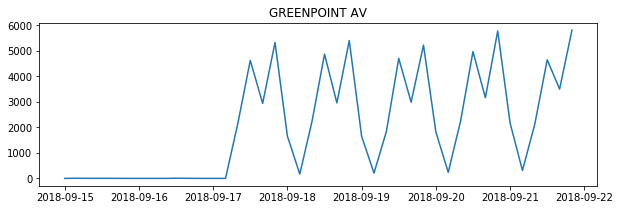

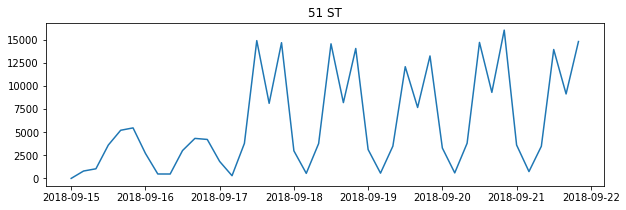

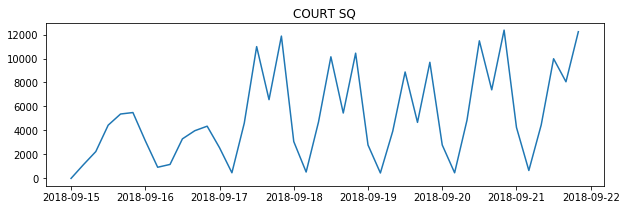

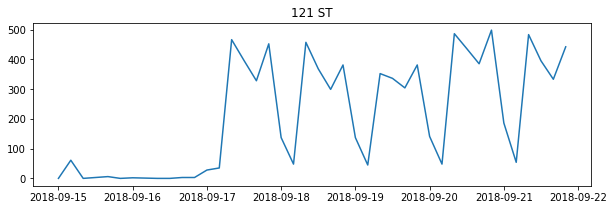

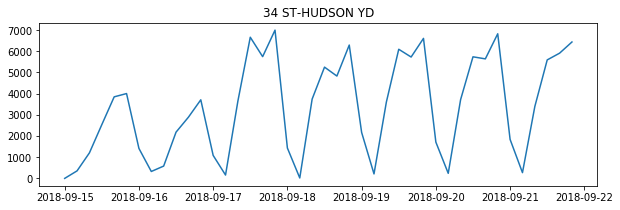

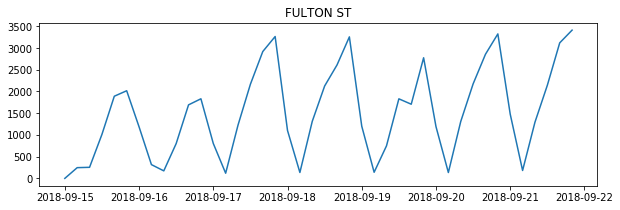

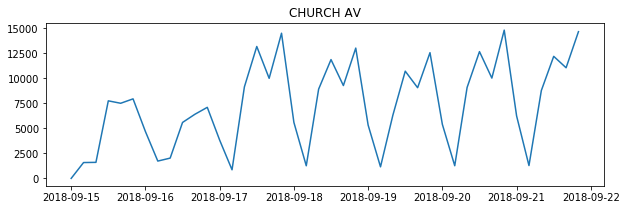

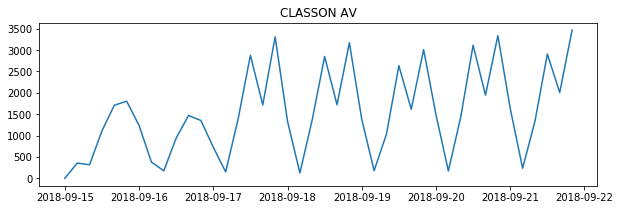

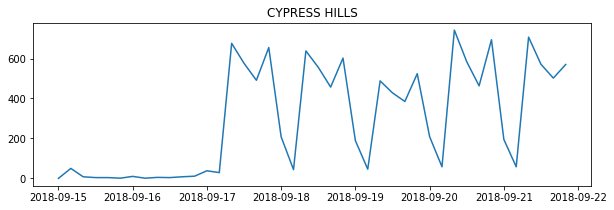

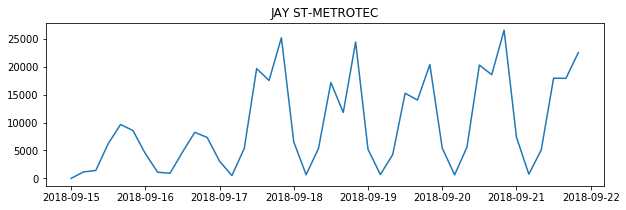

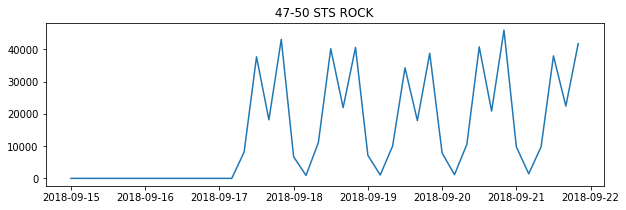

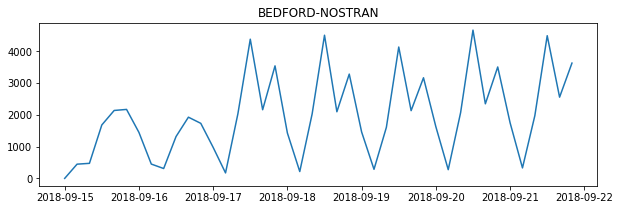

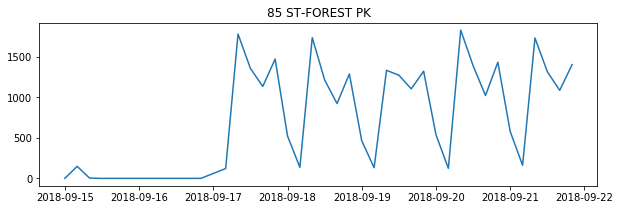

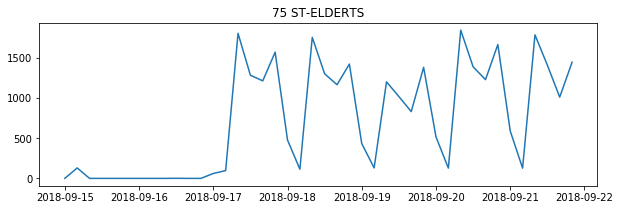

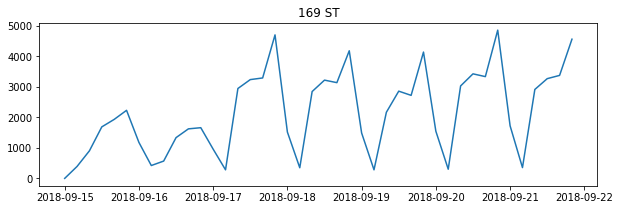

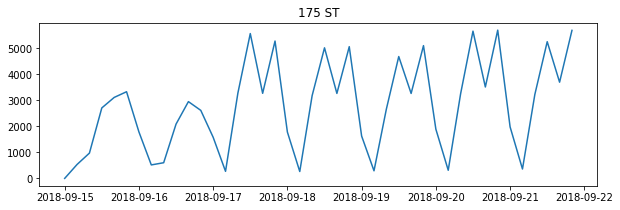

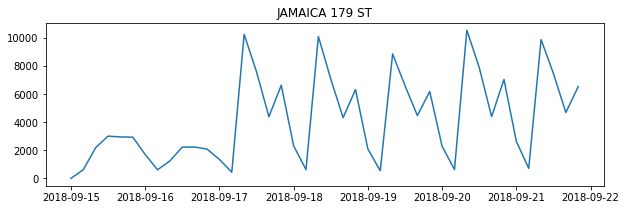

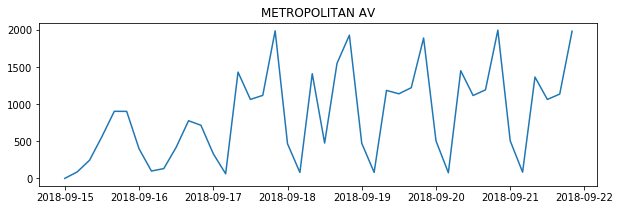

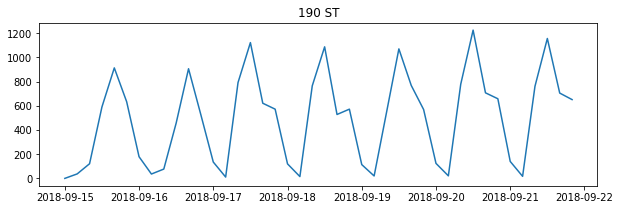

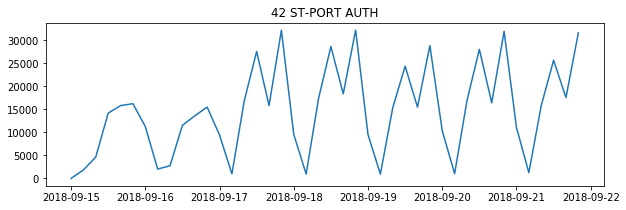

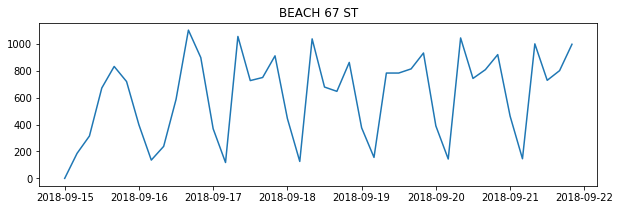

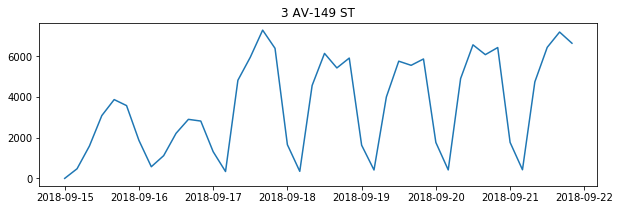

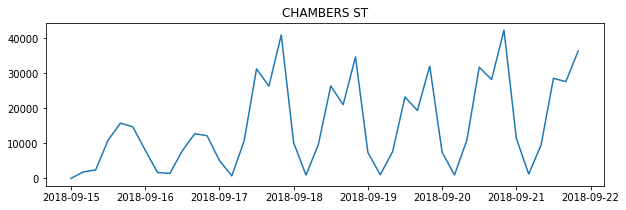

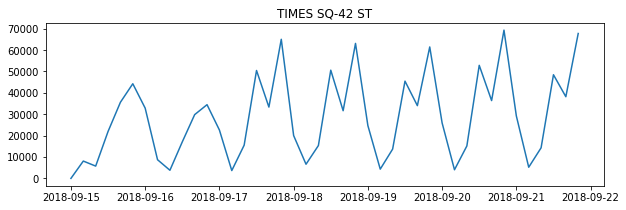

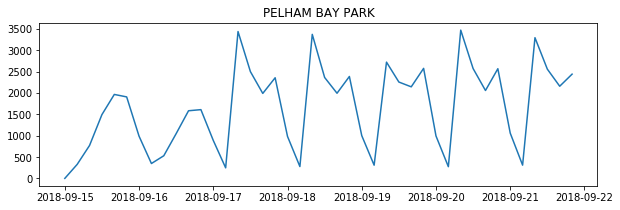

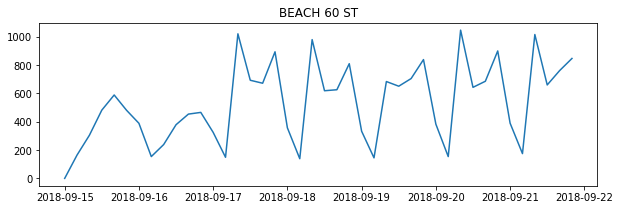

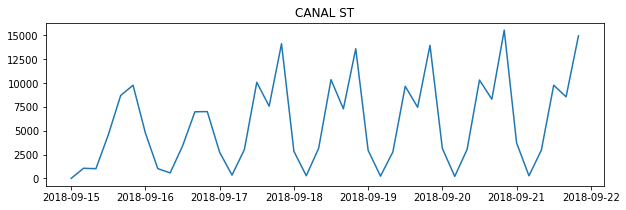

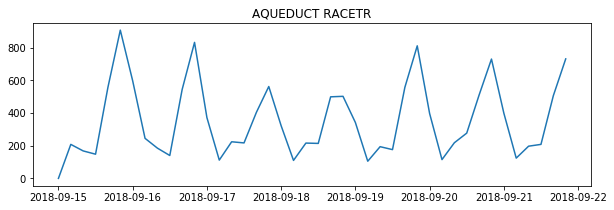

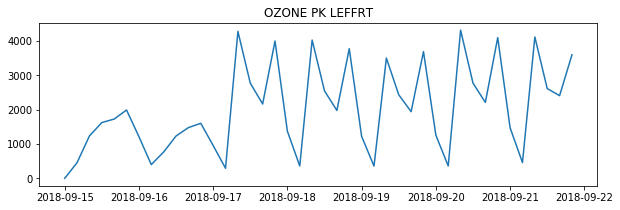

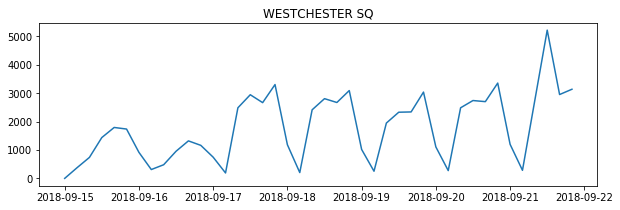

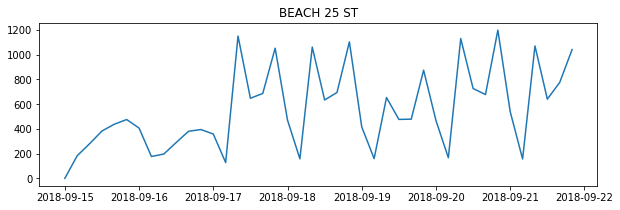

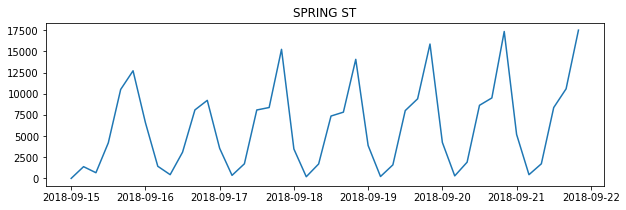

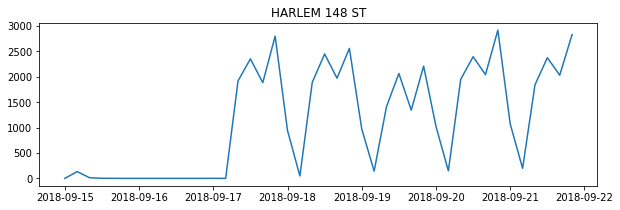

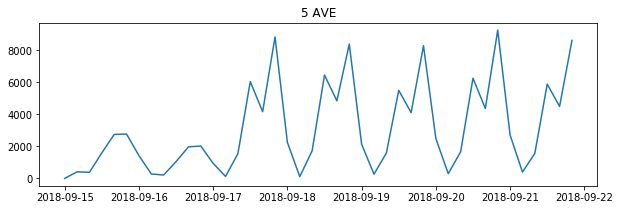

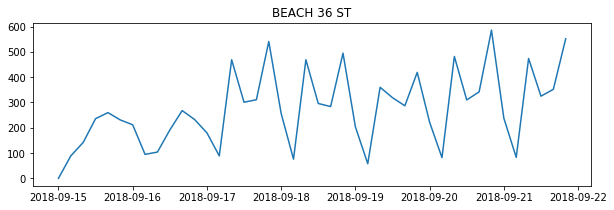

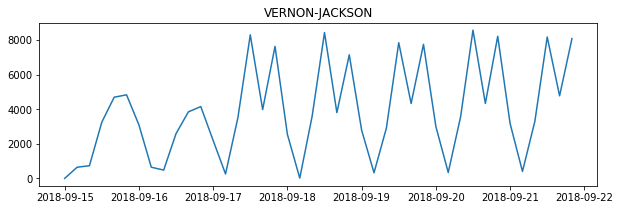

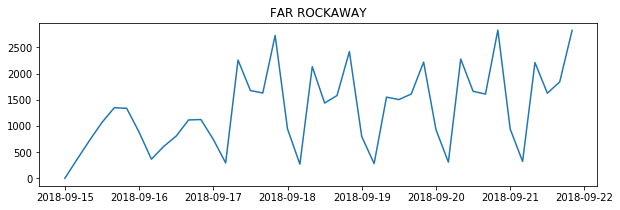

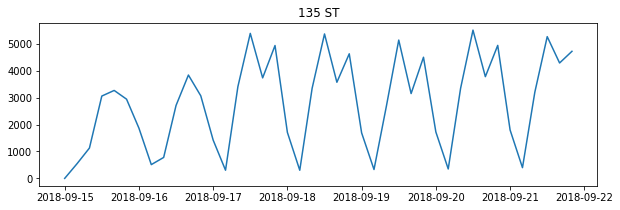

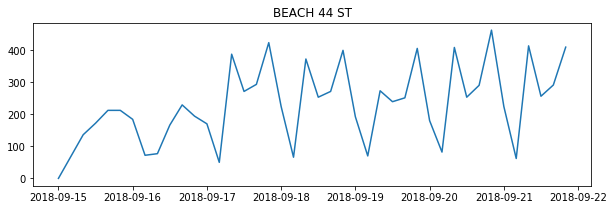

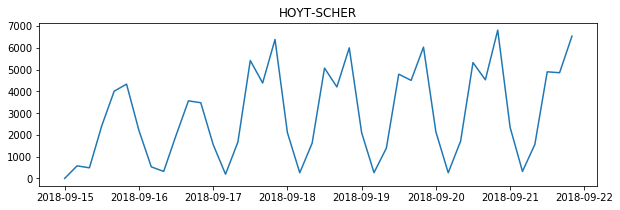

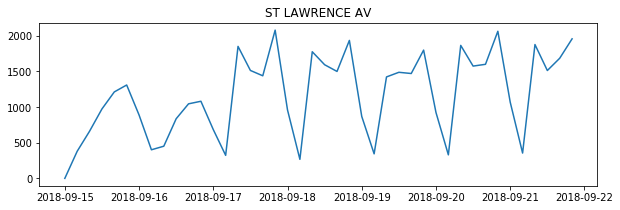

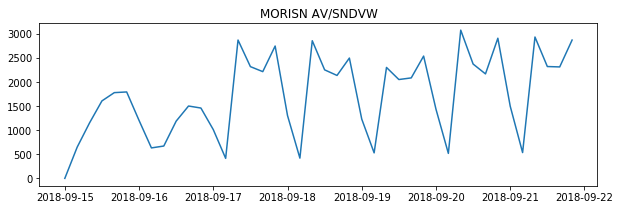

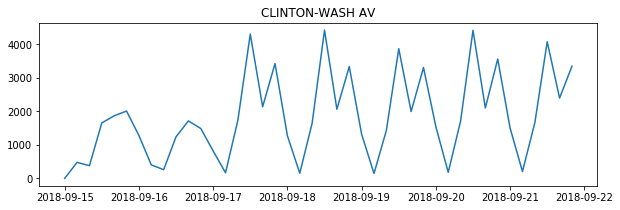

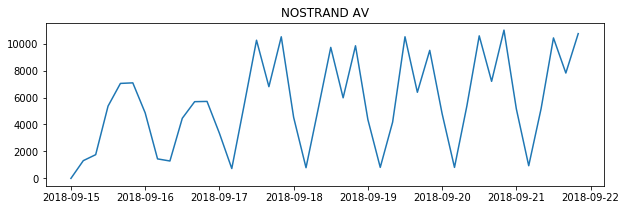

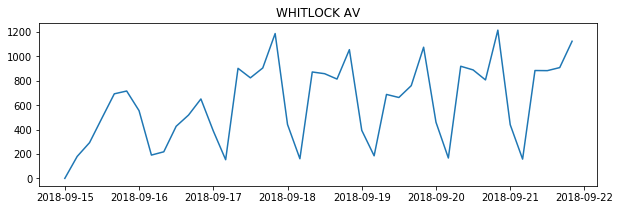

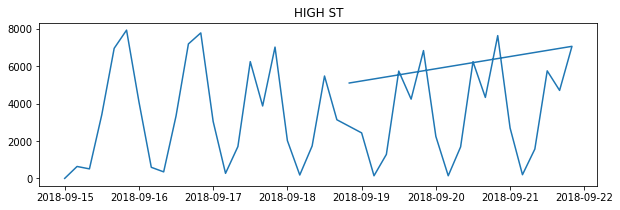

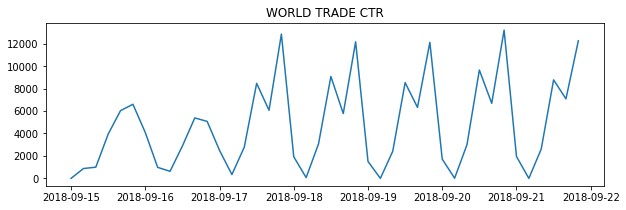

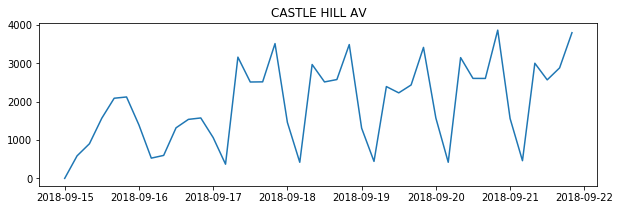

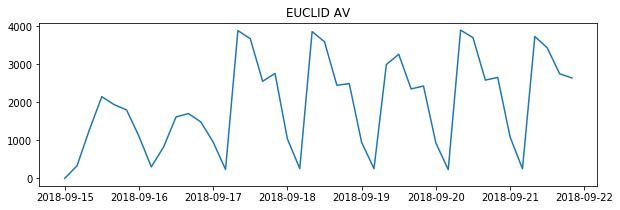

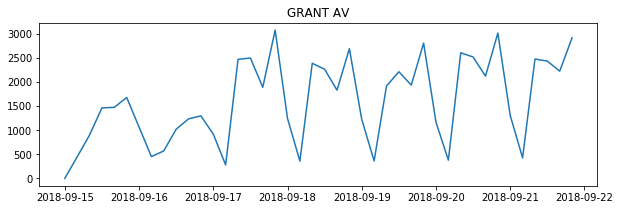

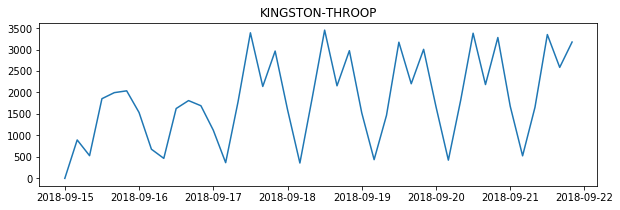

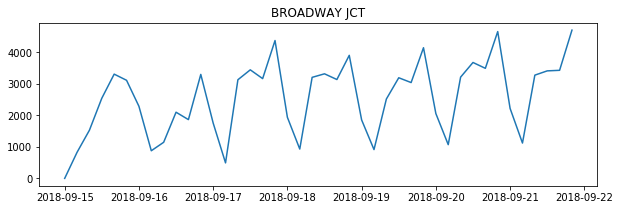

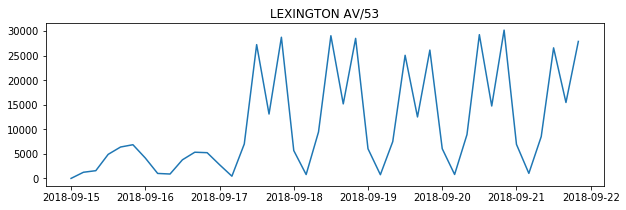

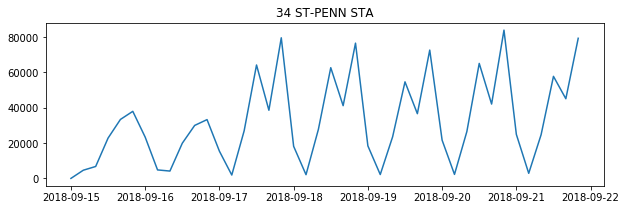

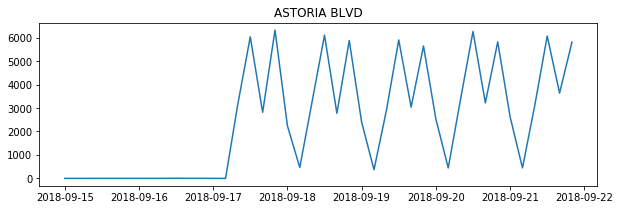

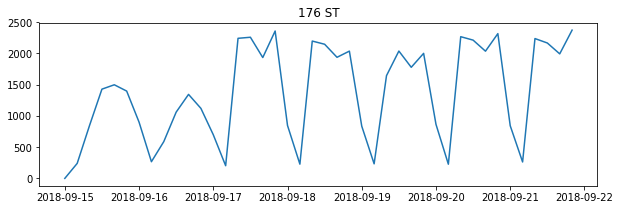

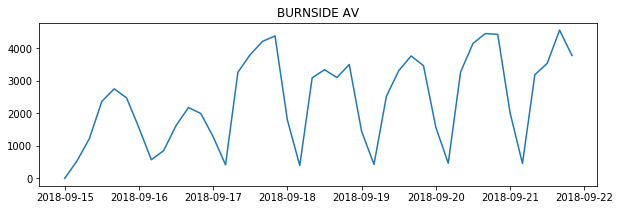

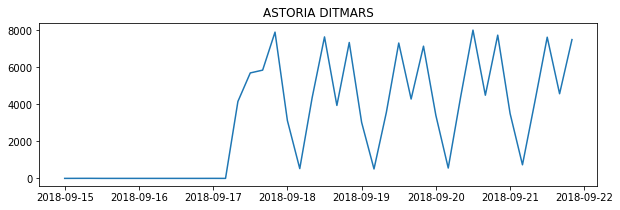

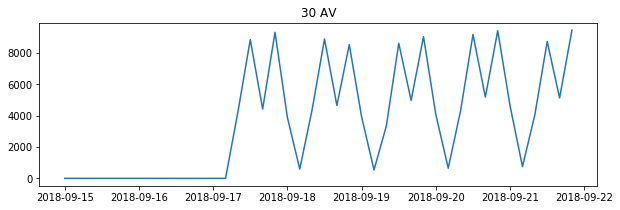

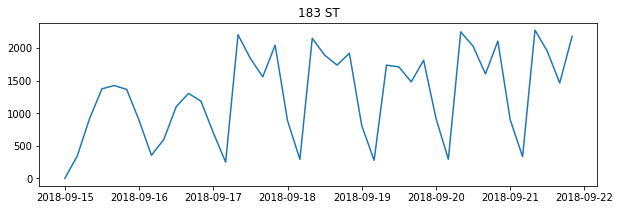

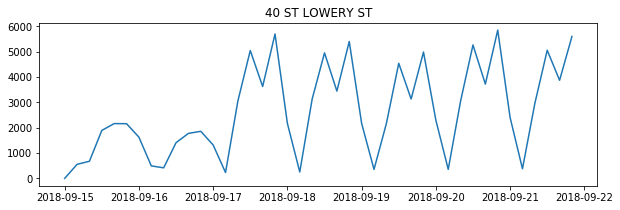

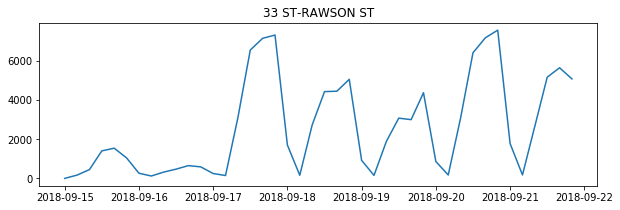

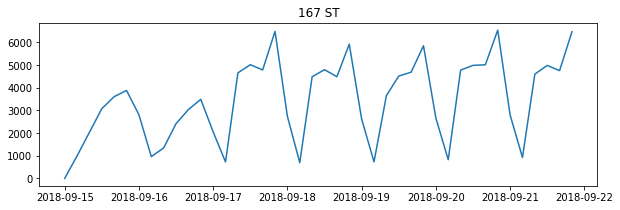

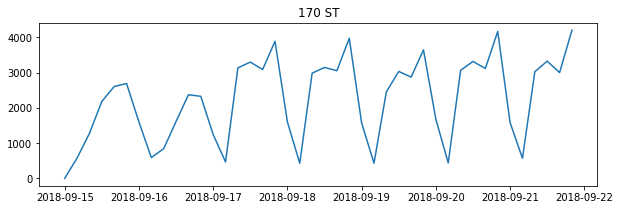

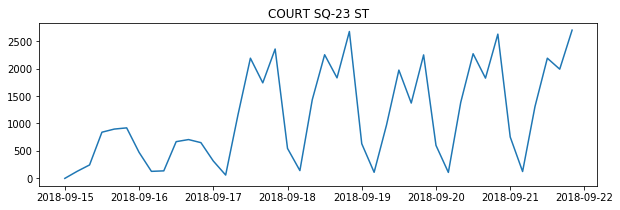

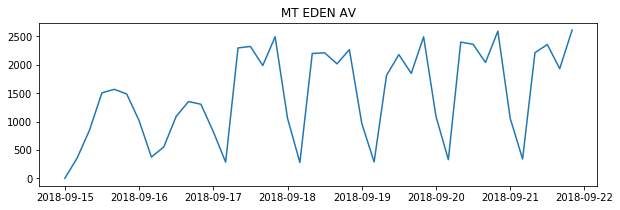

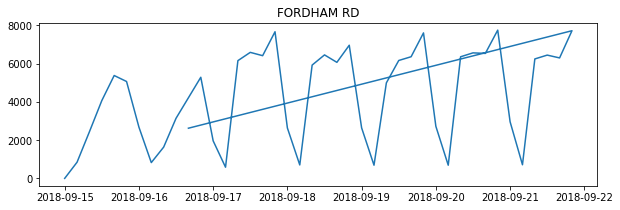

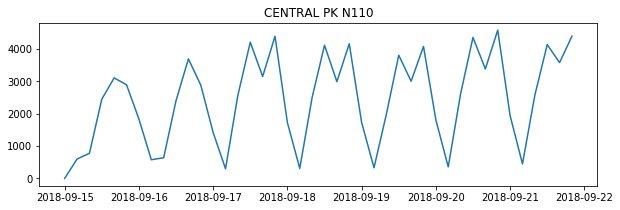

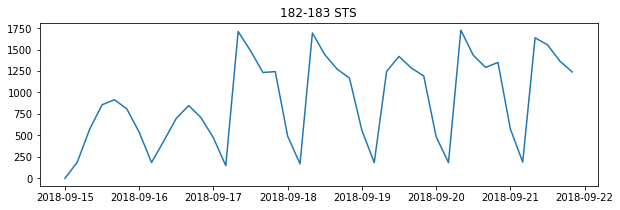

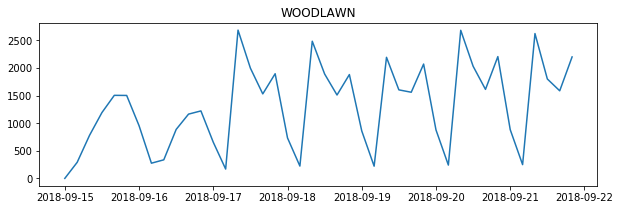

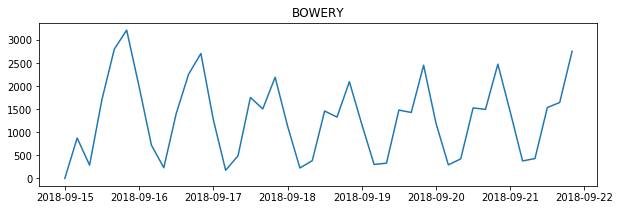

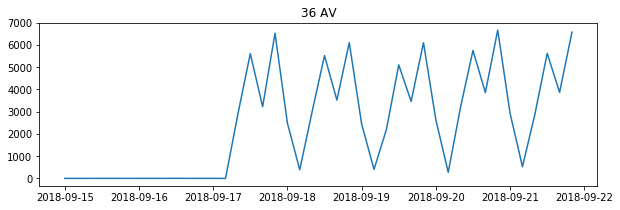

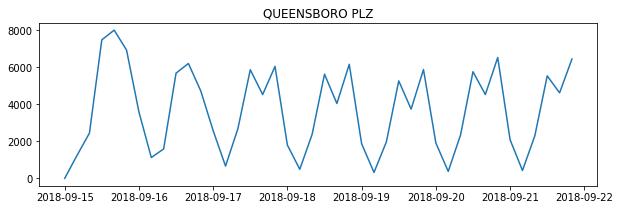

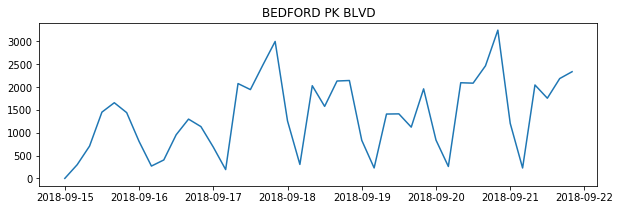

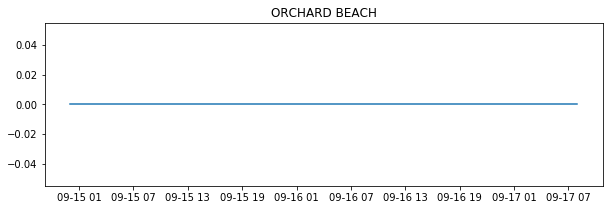

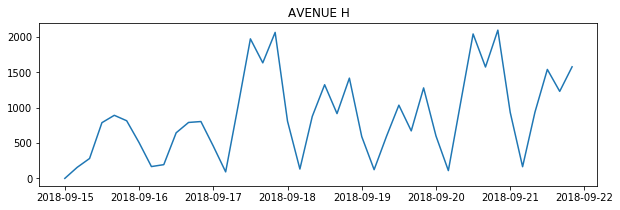

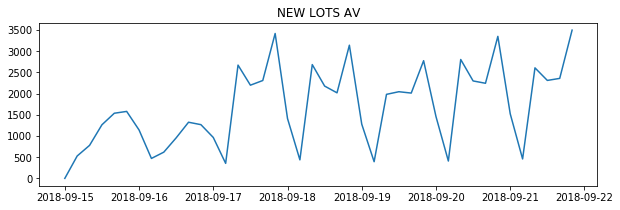

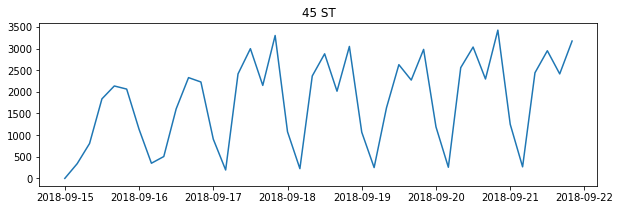

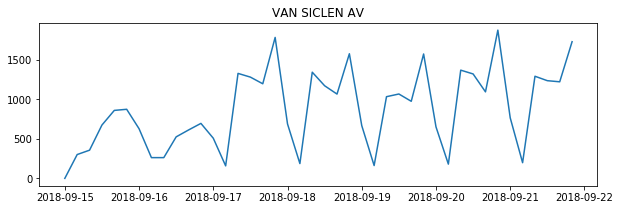

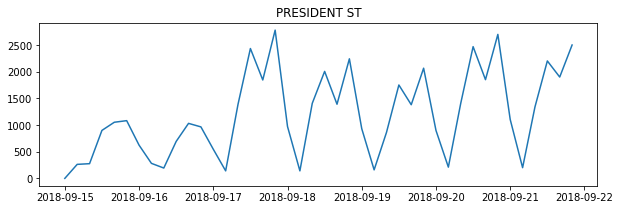

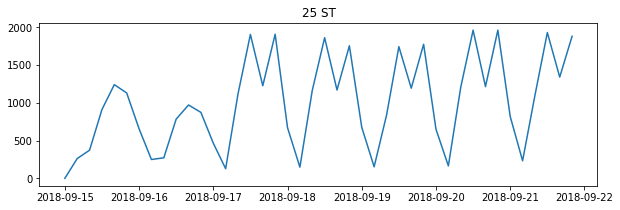

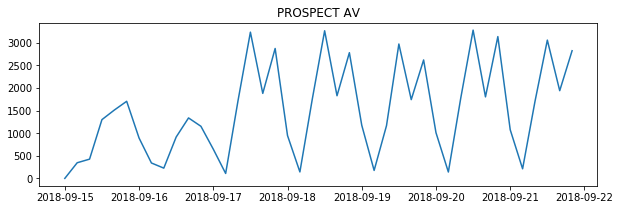

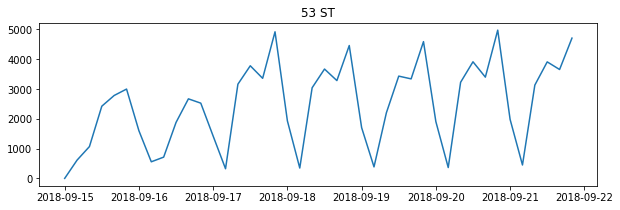

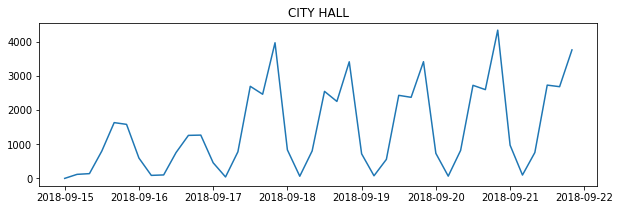

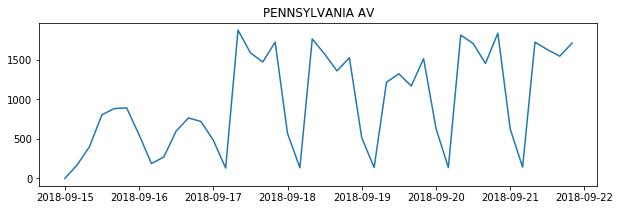

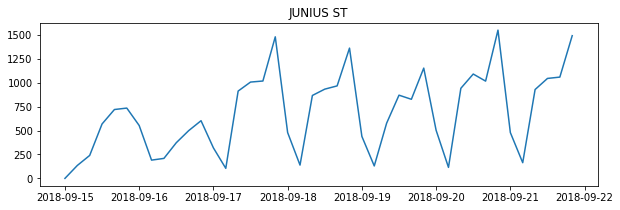

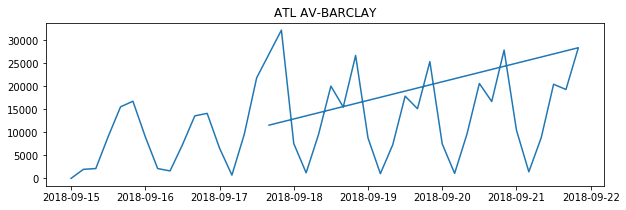

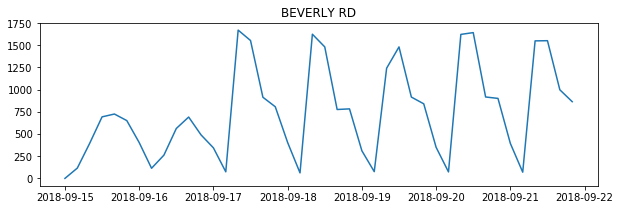

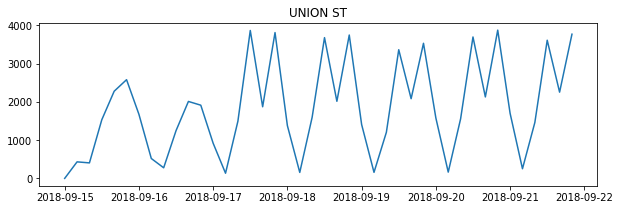

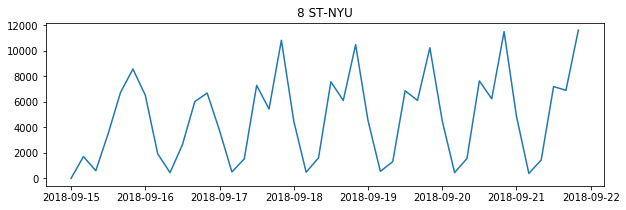

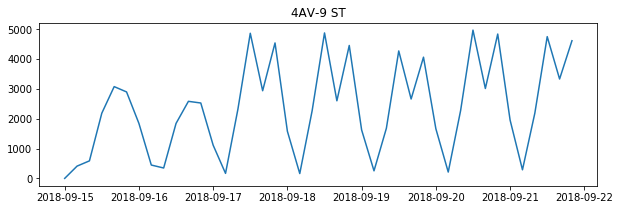

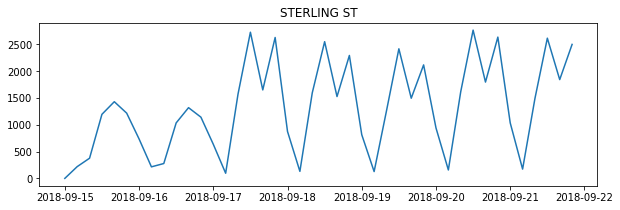

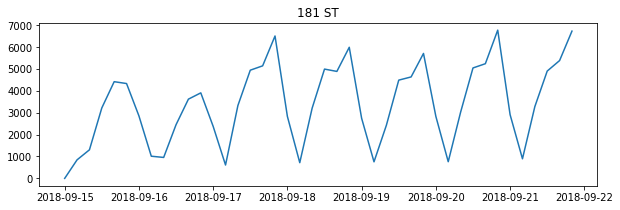

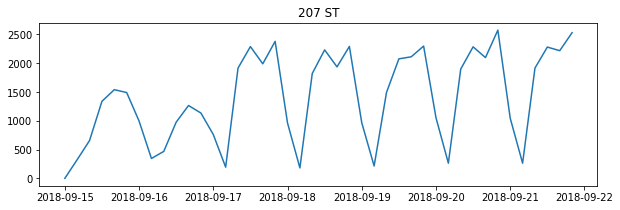

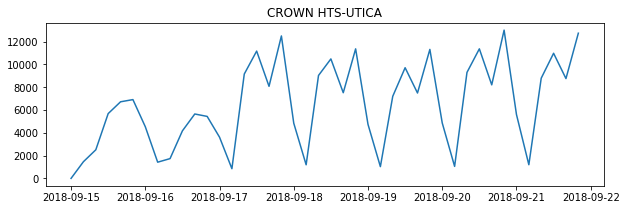

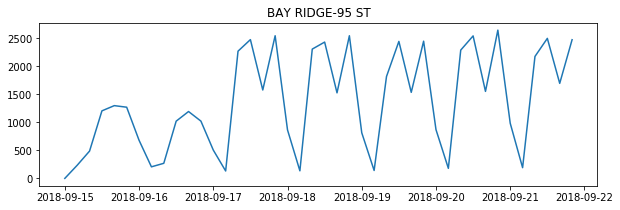

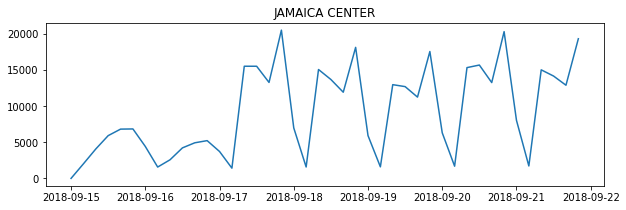

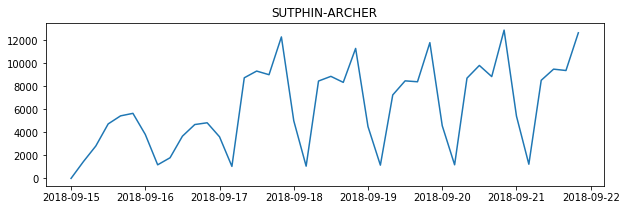

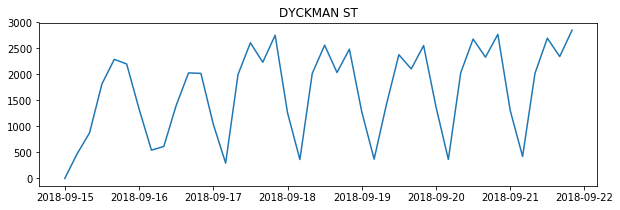

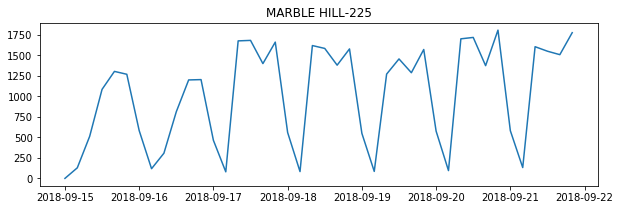

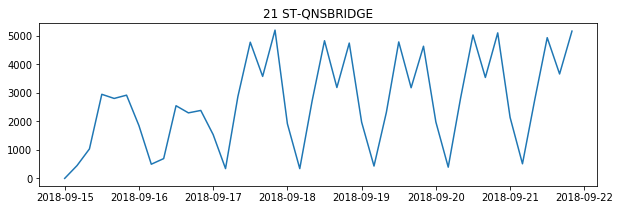

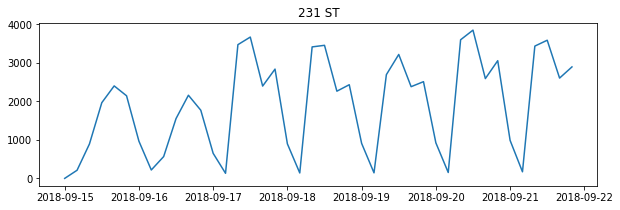

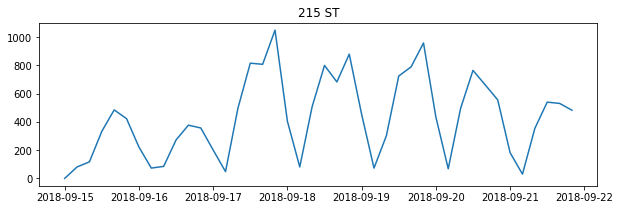

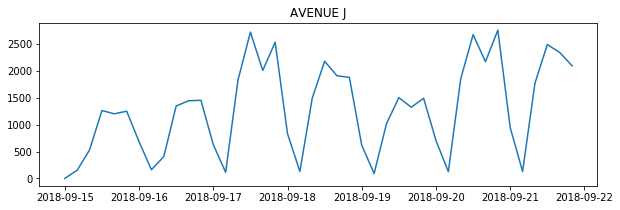

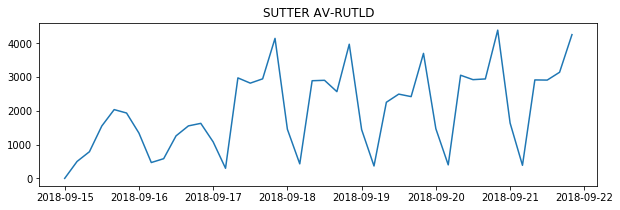

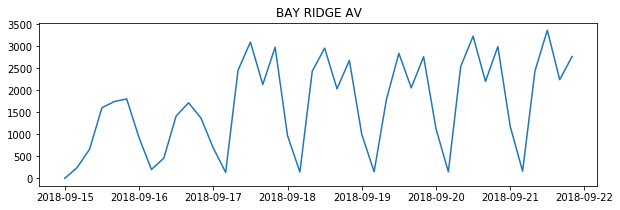

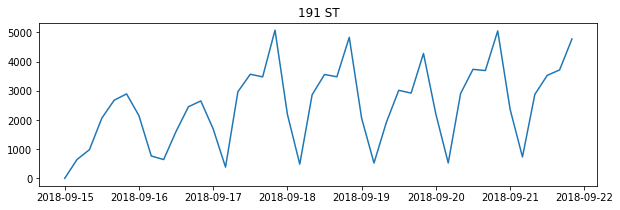

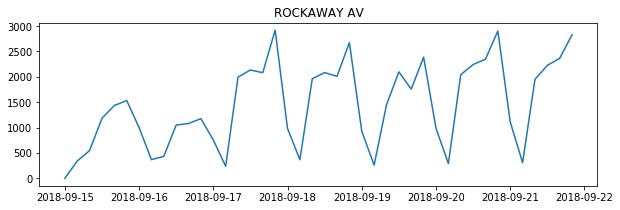

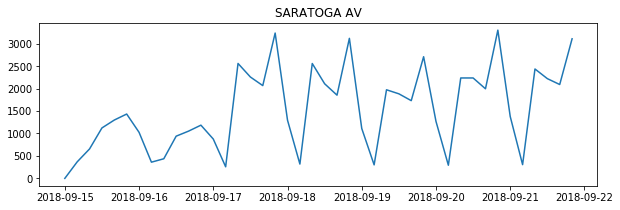

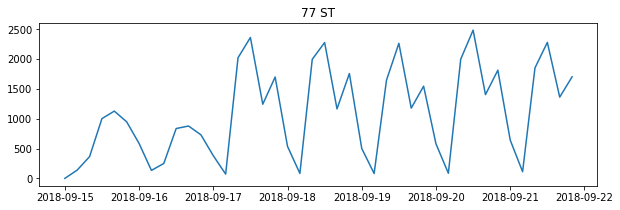

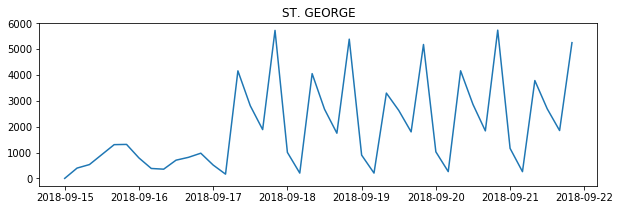

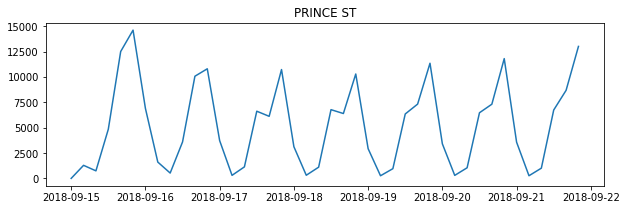

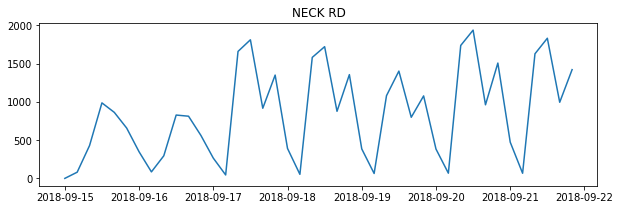

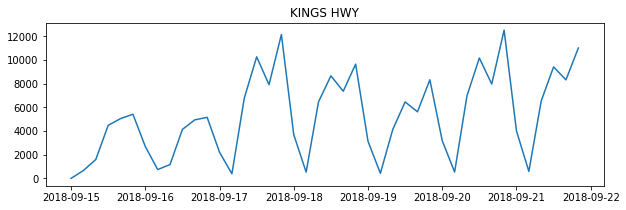

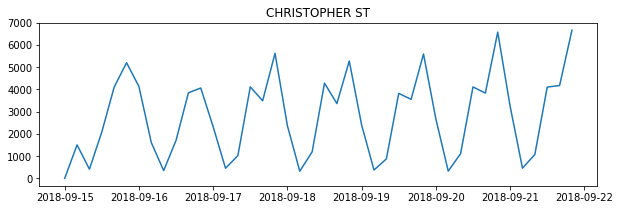

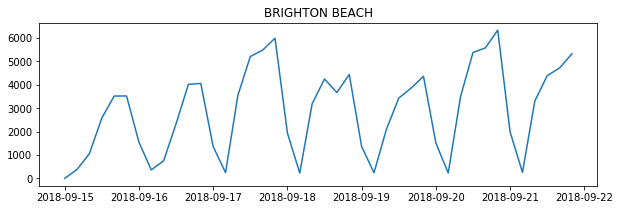

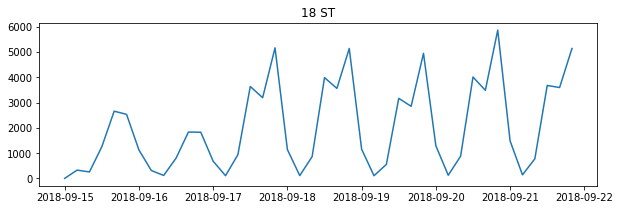

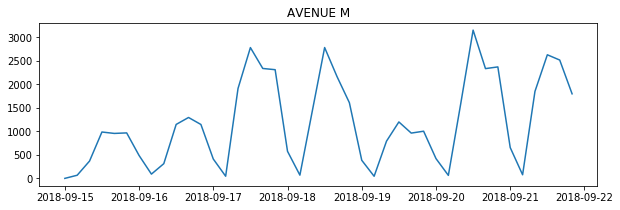

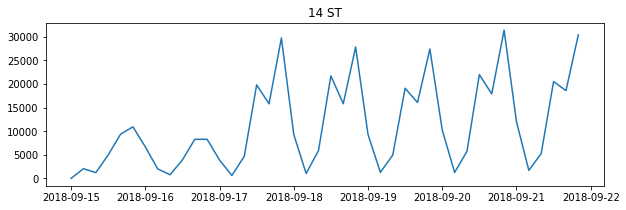

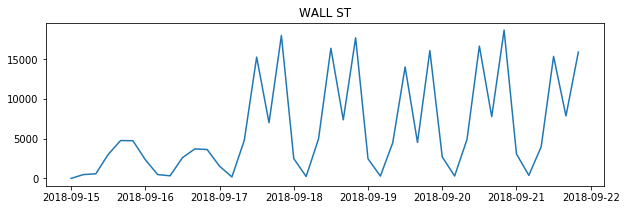

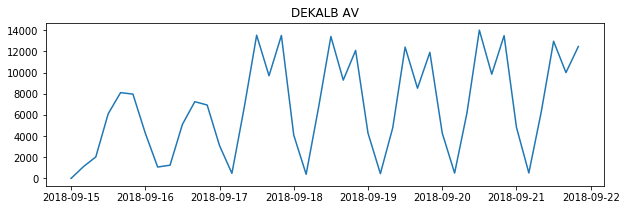

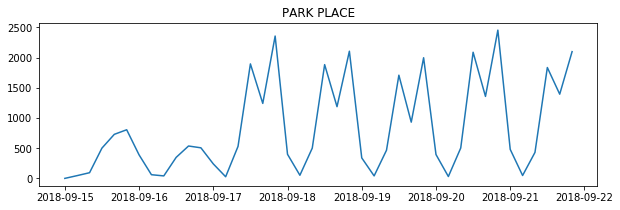

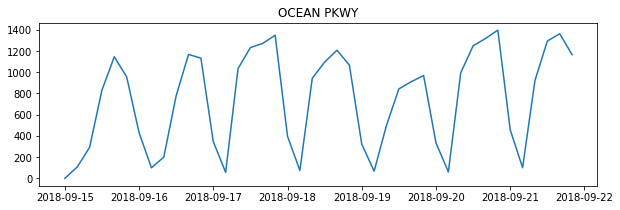

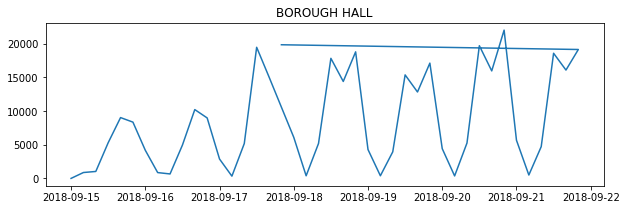

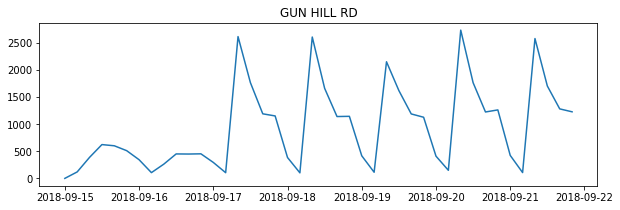

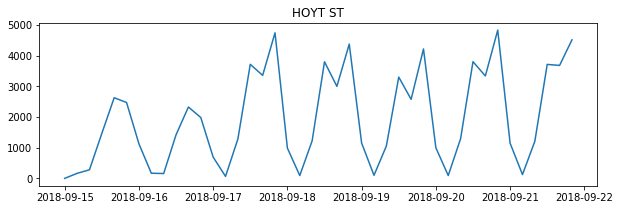

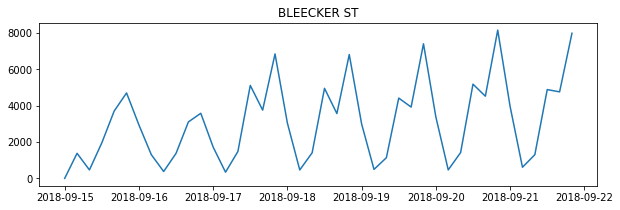

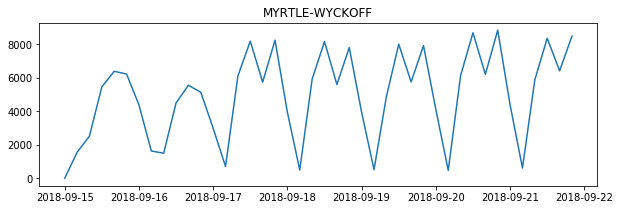

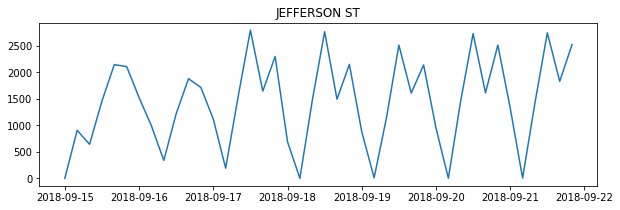

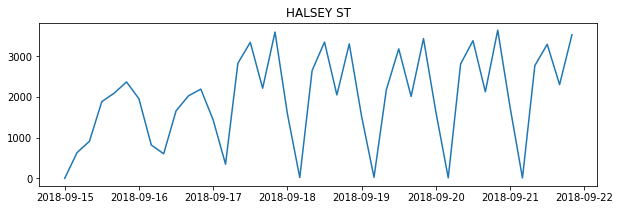

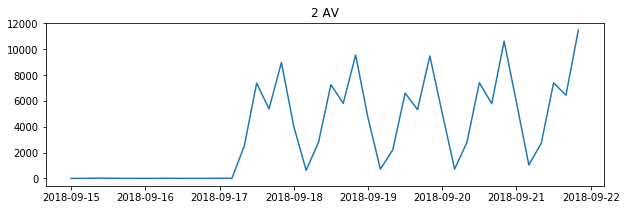

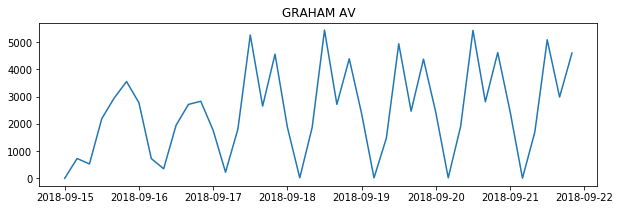

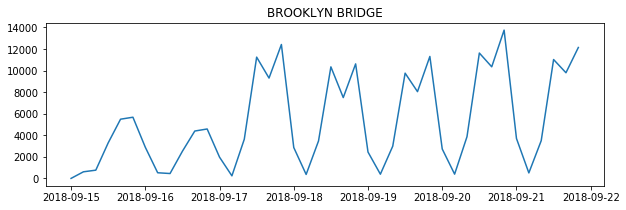

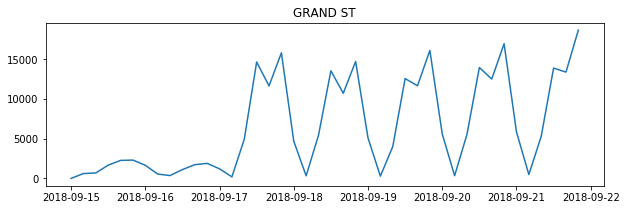

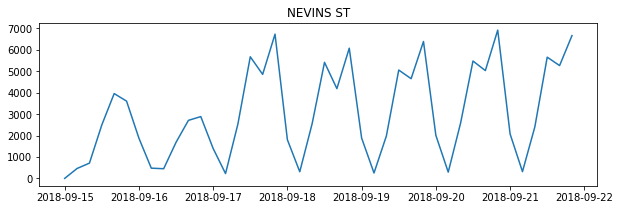

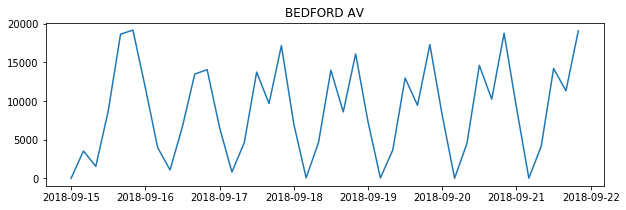

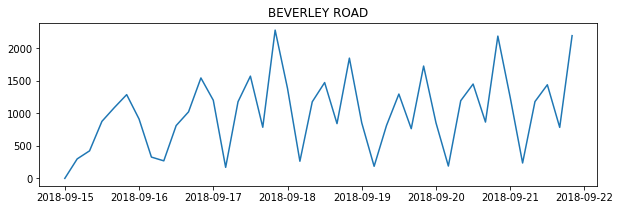

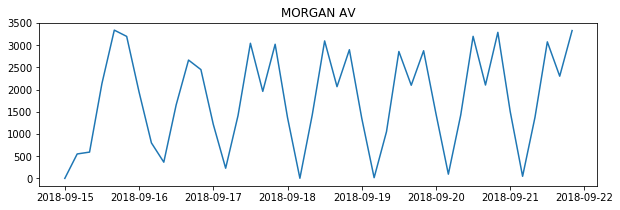

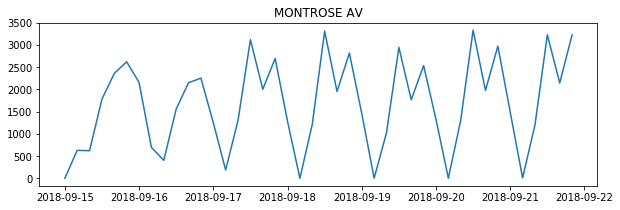

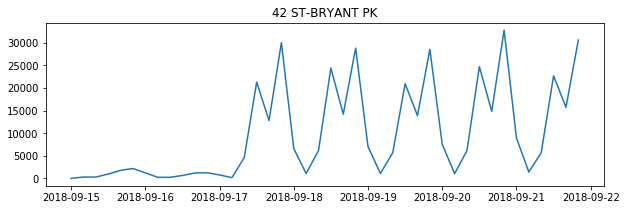

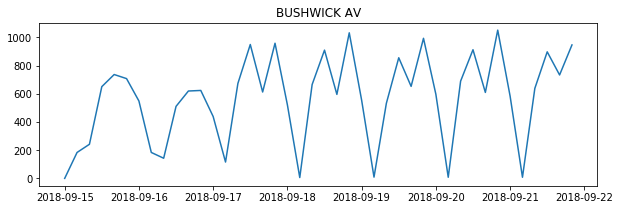

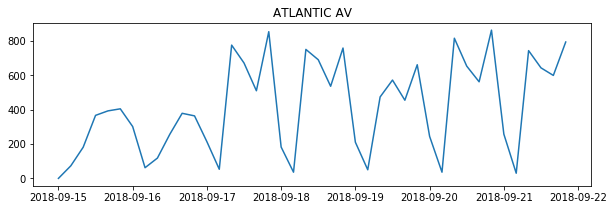

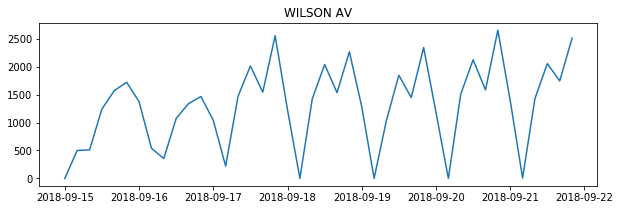

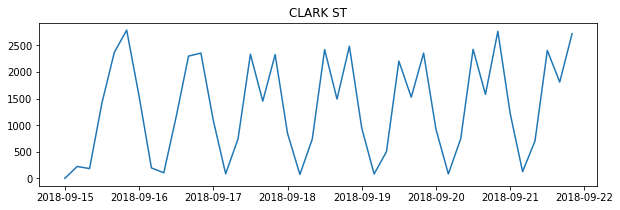

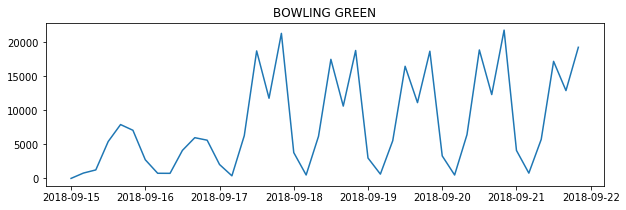

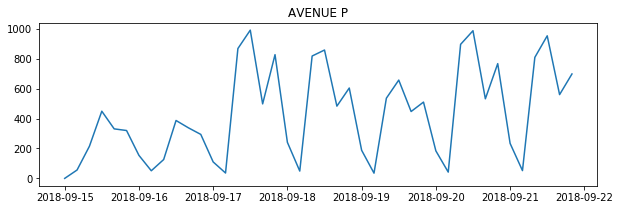

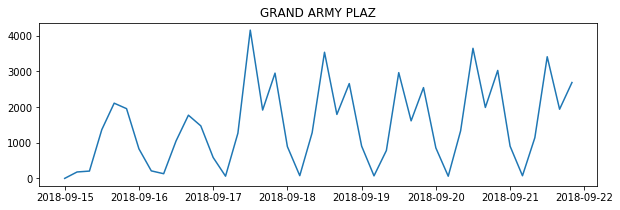

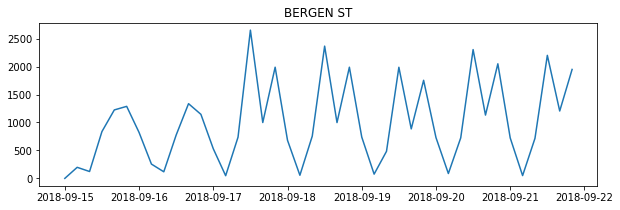

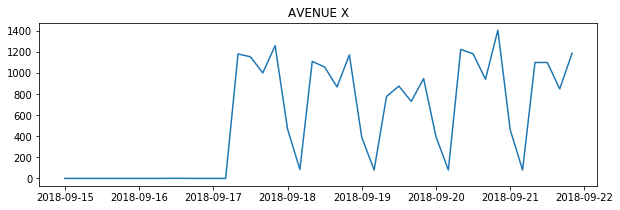

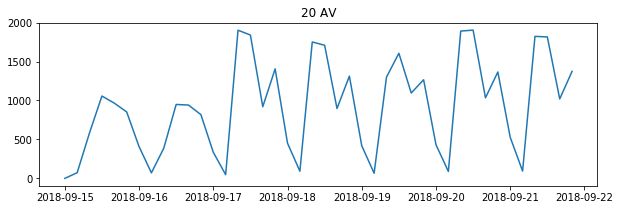

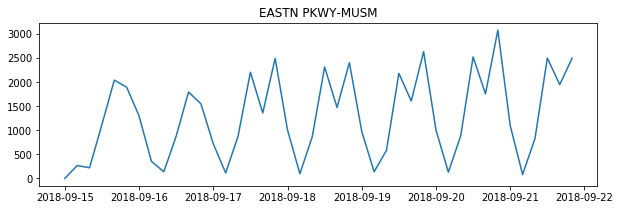

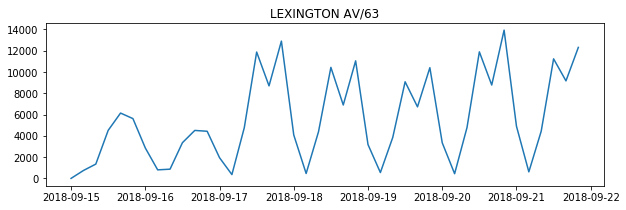

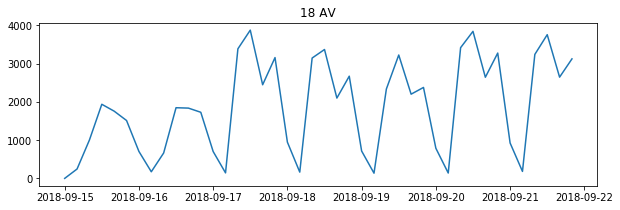

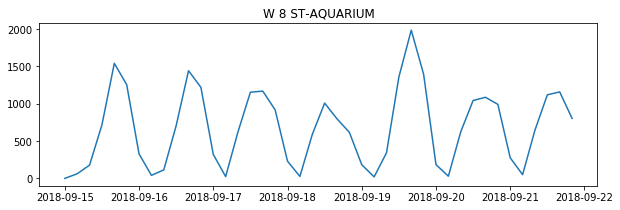

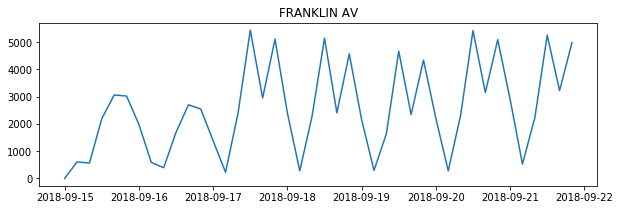

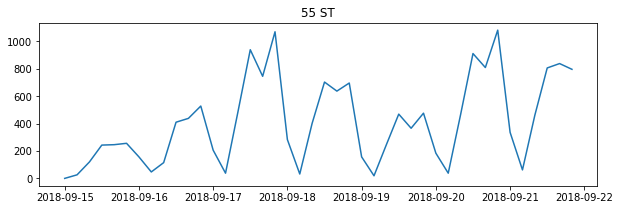

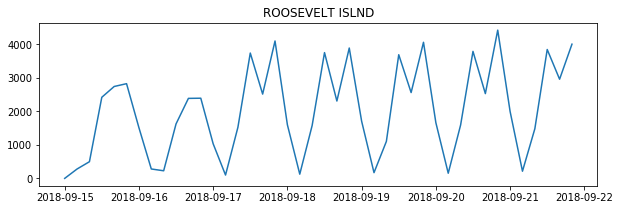

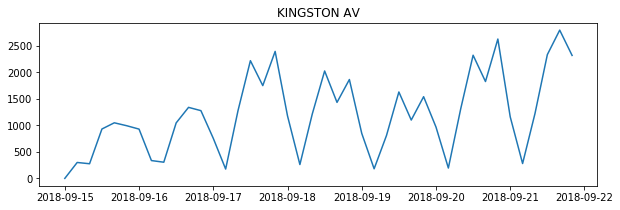

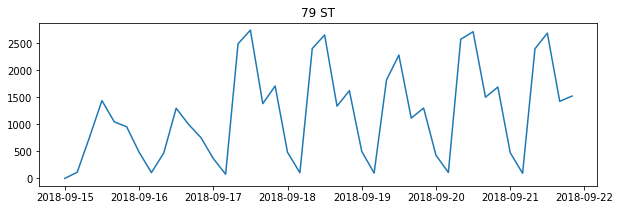

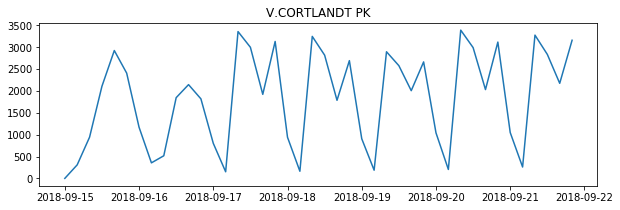

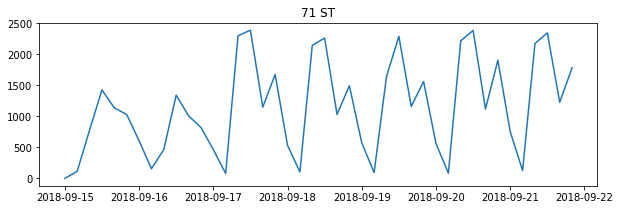

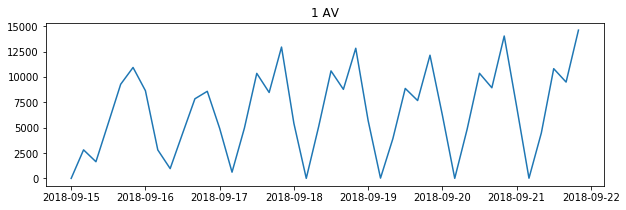

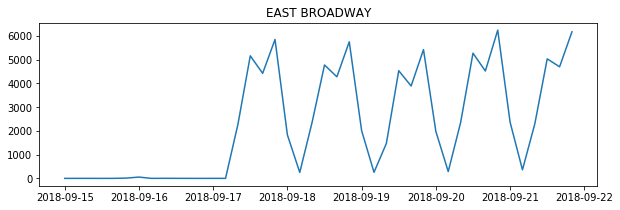

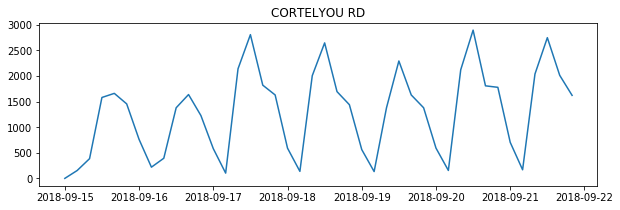

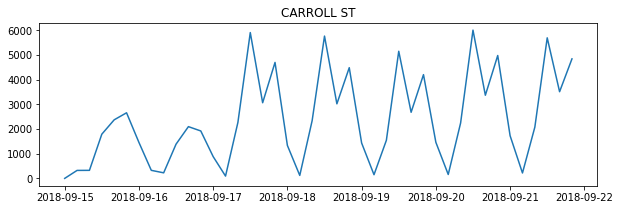

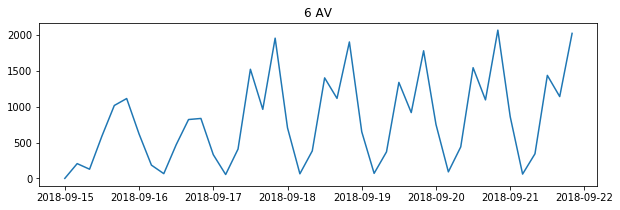

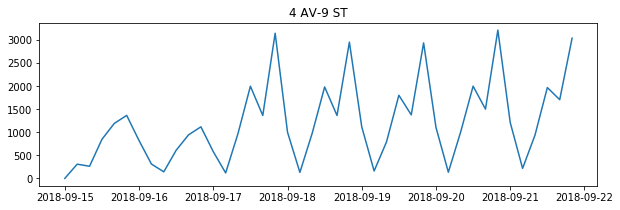

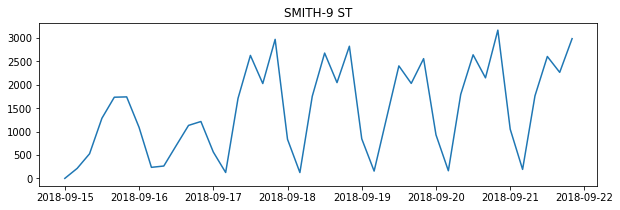

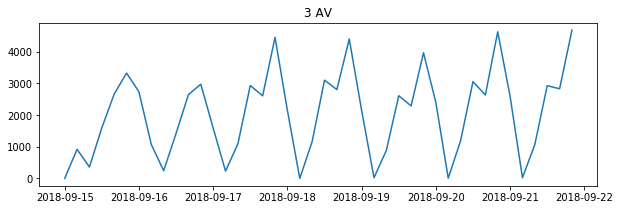

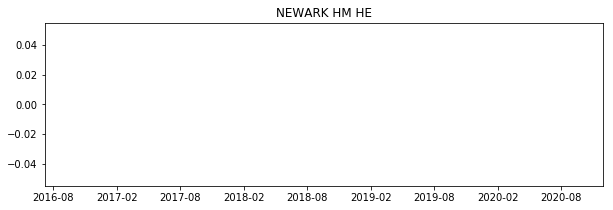

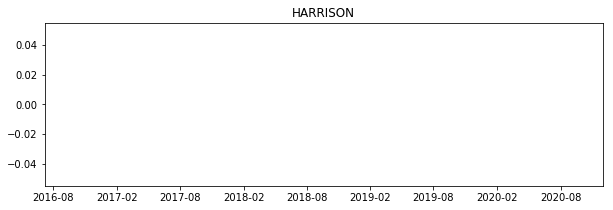

In [40]:
for key in challenge7:
    dates = []
    counts = []
    for entry in challenge7[key]:
        dates.append(entry[0])
        counts.append(entry[1])
    plt.figure(figsize=(10,3))    
    plt.plot(dates,counts)
    plt.title(key)

/home/michael/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


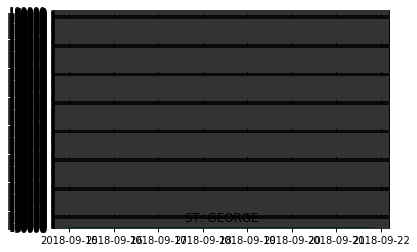

In [13]:
fig, ax = plt.subplots(len(challenge7), sharex=True, sharey=True)

i= 0
for key in challenge7:
    dates = []
    counts = []
    for entry in challenge7[key]:
        dates.append(entry[0])
        counts.append(entry[1])
    ax[i]=plt.plot(dates,counts)
    ax[i]=plt.title(key)
    i +=1
    
fig.show()

In [27]:
"""
problems are:
['BOROUGH HALL', 'ATL AV-BARCLAY', '86 ST','168 ST',
'FORDHAM ROAD','36 AV', '46ST BLISS']
"""

challenge7[('BOROUGH HALL')]

[[Timestamp('2018-09-15 00:00:00'), 0],
 [Timestamp('2018-09-15 04:00:00'), 873],
 [Timestamp('2018-09-15 08:00:00'), 1030],
 [Timestamp('2018-09-15 12:00:00'), 5301],
 [Timestamp('2018-09-15 16:00:00'), 9038],
 [Timestamp('2018-09-15 20:00:00'), 8362],
 [Timestamp('2018-09-16 00:00:00'), 4180],
 [Timestamp('2018-09-16 04:00:00'), 863],
 [Timestamp('2018-09-16 08:00:00'), 660],
 [Timestamp('2018-09-16 12:00:00'), 4944],
 [Timestamp('2018-09-16 16:00:00'), 10225],
 [Timestamp('2018-09-16 20:00:00'), 8985],
 [Timestamp('2018-09-17 00:00:00'), 2876],
 [Timestamp('2018-09-17 04:00:00'), 333],
 [Timestamp('2018-09-17 08:00:00'), 5177],
 [Timestamp('2018-09-17 12:00:00'), 19486],
 [Timestamp('2018-09-17 16:00:00'), 15078],
 [Timestamp('2018-09-18 00:00:00'), 6103],
 [Timestamp('2018-09-18 04:00:00'), 387],
 [Timestamp('2018-09-18 08:00:00'), 5188],
 [Timestamp('2018-09-18 12:00:00'), 17845],
 [Timestamp('2018-09-18 16:00:00'), 14408],
 [Timestamp('2018-09-18 20:00:00'), 18809],
 [Timestamp('

#### Challenge 9

- Over multiple weeks, sum total ridership for each station and sort
  them, so you can find out the stations with the highest traffic
  during the time you investigate

In [62]:
df1 = pd.read_csv('turnstile_180922.txt')
df2 = pd.read_csv('turnstile_180915.txt')
df3 = pd.read_csv('turnstile_180908.txt')
df4 = pd.read_csv('turnstile_180901.txt')

df = pd.concat([df1, df2, df3, df4])

df.rename(index=str, columns={df.columns[-1]: "EXITS"}, inplace=True)

dt = df.DATE + ' '+ df.TIME

df['DATETIME'] = pd.to_datetime(dt, infer_datetime_format=True)
df=df.sort_values(by='DATETIME')
mydict = collections.defaultdict(list)

for row in df.itertuples():
    key = (row[1], row[2], row[3], row[4])
    value = [row[5], row[6], row[9], row[12], row[10], row[11]]
    mydict[key].append(value)

In [65]:
challenge2 = collections.defaultdict(list)

for key in mydict:
    entries = mydict[key]
    lastentry = entries[0][4]
    lastexit = entries[0][5]
    for entry in entries:
        check_entry = entry[4]-lastentry
        if check_entry < 0:
            check_entry = 0
        if check_entry > 75000 :
            check_entry = 0
        check_exit = entry[5]-lastexit
        if check_exit < 0:
            check_exit = 0
        if check_exit > 75000 :
            check_exit = 0
        value = [entry[3], check_entry+check_exit]
        lastentry = entry[4]
        lastexit = entry[5]
        challenge2[key].append(value)
print(challenge2[('A002', 'R051', '02-00-00', '59 ST')][0:5])

[[Timestamp('2018-08-25 00:00:00'), 0], [Timestamp('2018-08-25 04:00:00'), 24], [Timestamp('2018-08-25 08:00:00'), 59], [Timestamp('2018-08-25 12:00:00'), 160], [Timestamp('2018-08-25 16:00:00'), 239]]


In [68]:
challenge3= collections.defaultdict(list)

dates = collections.defaultdict(int)

for key in challenge2:
    entries = challenge2[key]
    for entry in entries:
        date = entry[0].date()
        dates[date] += entry[1]
    for date in dates:
        challenge3[key].append([date, dates[date]])
        
challenge6 = collections.defaultdict(list)
dates = collections.defaultdict(int)

for key in challenge3:
    newkey = (key[3])
    dates = collections.defaultdict(int)
    for entry in challenge3[key]:
        dates[entry[0]] += entry[1]
    for date in dates:
        challenge6[newkey].append([date, dates[date]])

for key in challenge6:
    week = collections.defaultdict(int)
    for item in challenge6[key] :
        date=item[0]
        increase = item[1]
        week[date] += increase
    challenge6[key] = []
    for day in week:
        challenge6[key].append([day, week[day]])

challenge9 = collections.defaultdict(int)
for key in challenge6:
    for item in challenge6[key]:
        flow = item[1]
        challenge9[key] +=flow

In [74]:
challenge9_sorted = sorted(challenge9.items(), key=lambda x : x[1], reverse=True)
challenge9_sorted[0:20]

[('FULTON ST', 17020155148),
 ('CORTLANDT ST', 14284962536),
 ('PATH NEW WTC', 9038790089),
 ('34 ST-PENN STA', 8314538647),
 ('14 ST-UNION SQ', 7947794966),
 ('WALL ST', 7426137626),
 ('GRD CNTRL-42 ST', 7206332592),
 ('23 ST', 6774826428),
 ('CANAL ST', 6511875167),
 ('METS-WILLETS PT', 6133158258),
 ('96 ST', 5509359935),
 ('EXCHANGE PLACE', 5460025882),
 ('42 ST-PORT AUTH', 5308861303),
 ('14 ST', 5297459571),
 ('161/YANKEE STAD', 4842106153),
 ('LACKAWANNA', 4779111881),
 ('125 ST', 4637048075),
 ('5 AV/53 ST', 4619287538),
 ('CITY / BUS', 4570098128),
 ('HARRISON', 4493486860)]

#### Challenge 10

- Make a single list of these total ridership values and plot it with

  plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among
different stations.

This should show you that most stations have a small traffic, and the
histogram bins for large traffic volumes have small bars.

*Additional Hint*:

If you want to see which stations take the meat of the traffic, you
can sort the total ridership counts and make a `plt.bar` graph. For
this, you want to have two lists: the indices of each bar, and the
values. The indices can just be `0,1,2,3,...`, so you can do

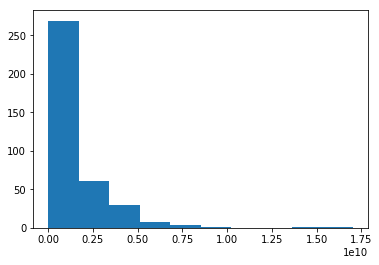

In [76]:
total_ridership_counts = []

for key in challenge9:
    total_ridership_counts.append(challenge9[key])
    
plt.hist(total_ridership_counts);